# PCNA Glimpse generation

This notebook is designed to generate large amount of cropped images of cells with the PCNA-irfp marker for a cluster analysis

In [64]:
import btrack
import matplotlib.pyplot as plt
import os, glob, re
from skimage.io import imread, imsave, imshow
from tqdm import tqdm
import numpy as np
from pathlib import Path
import shutil
from natsort import natsorted
from PIL import Image
import warnings
warnings.filterwarnings('ignore') ###bc imsave throws up low contrast warnings

# Set params

In [56]:
log = []

expt_root_folder = '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi'

expt = 'MK0000'

channels = ['003'] ### bf 000 gfp 001 rfp 002 irfp 003

focal_time_range = (0, 800) ### this particular expt stays in focus in this time range

glimpse_size = (64,64)

pos_list = natsorted([pos for pos in os.listdir(os.path.join(expt_root_folder, expt)) if 'Pos' in pos])

In [57]:
for pos in tqdm(pos_list):
    try:
        print('starting', pos)
        tracks_path_list = glob.glob(os.path.join(expt_root_folder,'{}/{}/gfp*.h5'.format(expt,pos)))
        if len(tracks_path_list) == 1:
            tracks_path = tracks_path_list[0]
        else:
            continue
        with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_1") as hdf:
            wt_tracks = hdf.tracks

        message = str(pos) + 'tracking file loaded'
        log.append(message)
        print(message)

        ### filter tracks that should contain a full cell cycle in (1 timepoint/frame = 4min, cc time approx 200 frames based on quick look)
        long_tracks = [track for track in wt_tracks if len(track) > 200]

        ### filter tracks that spend a lot of time out of focus
        tracks = [track for track in long_tracks if track.t[-1] < focal_time_range[1]]

        ### show number of filtered tracks
        message = str(pos)+'number of glimpses to be generated:'+str(len(tracks))
        log.append(message)
        print(message)

        ### find images and set output
        image_folder = os.path.join(expt_root_folder,expt, pos, pos+'_stacks')
        output_dir = '/home/nathan/data/kraken/pcna/glimpses/{}/{}'.format(expt, pos)

        for channel in channels:
            ### load images
            print('Loading image channel', channel)
            images = imread(os.path.join(image_folder, 'channel{}.tif'.format(channel)))
            print('Image loaded')
            message = str(pos) + 'image loaded'
            log.append(message)

            ### create output directory
            output_ch_dir = os.path.join(output_dir, 'channel'+channel)
            Path(output_ch_dir).mkdir(parents=True, exist_ok=True)

            for cell in tqdm(tracks):
                try:
                    message = 'attempting' + str(pos) + 'cell ID' + str(cell.ID)
                    log.append(message)
                    print(message)

                    ### get length of track/glimpse 
                    length = range(cell.t[0], cell.t[-1])
                    ### get the xy coords of track/glimpse 
                    y, x = cell.x, cell.y #### WHY IS THE COORDINATES TRANSPOSED???? 

                    ### iterate over all frames cropping
                    for j, i in enumerate(length): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
                        ### obtain correct frame
                        image = images[i]
                        ### get glimpse dimensions 
                        size = int(glimpse_size[0])
                        ### obtain coordinates of bounding box of glimpse (centered on cell)
                        x1, x2, y1, y2 = x[j], x[j]+size, y[j], y[j]+size #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
                        ### pad image incase cell goes off FOV
                        image = np.pad(image, int(size/2), 'constant', constant_values = 0) 
                        ## glimpse creation by cropping original image
                        glimpse = image[int(x1): int(x2), int(y1): int(y2)]
                        ### fraction of track this frame is at
                        age = round(j/len(cell),3)
                        fn = str(pos)+'_cell_ID_' + str(cell.ID) + '_channel' + channel + '_t{}_age{}.tif'.format(i, age)
                        ### glimpse output
                        imsave(os.path.join(output_ch_dir, fn), glimpse) 

                    message = str(pos)+'cell ID'+ str(cell.ID) + 'glimpse saved'
                    print(message)
                    log.append(message)

                except:
                    message = str(cell.ID)+ 'failed to produce glimpse')
                    log.append(message)
                    print(message)
    except:
        message = 'something went big wrong on' +str(pos)
        log.append(message)
        print(message)

  0%|          | 0/24 [00:00<?, ?it/s][INFO][2021/05/27 06:56:52 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_21_05_29_08_PM.h5...
[INFO][2021/05/27 06:56:52 PM] Loading tracks/obj_type_1


starting Pos0


[INFO][2021/05/27 06:56:52 PM] Loading objects/obj_type_1 (563356, 5) (563356 filtered: None)
[INFO][2021/05/27 06:56:59 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_21_05_29_08_PM.h5


Pos0tracking file loaded
Pos0number of glimpses to be generated:275
Loading image channel 003



  0%|          | 0/275 [00:00<?, ?it/s]

Image loaded
attemptingPos0cell ID173



  0%|          | 1/275 [00:00<01:11,  3.84it/s]

Pos0cell ID173glimpse saved
attemptingPos0cell ID190



  1%|          | 2/275 [00:00<01:29,  3.06it/s]

190 failed to produce glimpse
attemptingPos0cell ID244



  1%|          | 3/275 [00:01<01:43,  2.64it/s]

Pos0cell ID244glimpse saved
attemptingPos0cell ID214



  1%|▏         | 4/275 [00:01<02:02,  2.21it/s]

Pos0cell ID214glimpse saved
attemptingPos0cell ID46



  2%|▏         | 5/275 [00:02<02:13,  2.03it/s]

Pos0cell ID46glimpse saved
attemptingPos0cell ID1183



  2%|▏         | 6/275 [00:02<01:53,  2.38it/s]

Pos0cell ID1183glimpse saved
attemptingPos0cell ID1445



  3%|▎         | 8/275 [00:03<01:30,  2.94it/s]

Pos0cell ID1445glimpse saved
attemptingPos0cell ID1438
Pos0cell ID1438glimpse saved
attemptingPos0cell ID1478



  3%|▎         | 9/275 [00:03<01:43,  2.58it/s]

Pos0cell ID1478glimpse saved
attemptingPos0cell ID1580



  4%|▎         | 10/275 [00:03<01:34,  2.80it/s]

Pos0cell ID1580glimpse saved
attemptingPos0cell ID1686



  4%|▍         | 12/275 [00:04<01:19,  3.31it/s]

Pos0cell ID1686glimpse saved
attemptingPos0cell ID1936
Pos0cell ID1936glimpse saved
attemptingPos0cell ID1984



  5%|▍         | 13/275 [00:04<01:22,  3.19it/s]

Pos0cell ID1984glimpse saved
attemptingPos0cell ID1826



  5%|▌         | 14/275 [00:05<01:23,  3.12it/s]

Pos0cell ID1826glimpse saved
attemptingPos0cell ID1783



  5%|▌         | 15/275 [00:05<01:18,  3.31it/s]

Pos0cell ID1783glimpse saved
attemptingPos0cell ID1796



  6%|▌         | 16/275 [00:05<01:19,  3.24it/s]

Pos0cell ID1796glimpse saved
attemptingPos0cell ID1867



  6%|▌         | 17/275 [00:05<01:15,  3.43it/s]

Pos0cell ID1867glimpse saved
attemptingPos0cell ID2087



  7%|▋         | 18/275 [00:06<01:18,  3.28it/s]

Pos0cell ID2087glimpse saved
attemptingPos0cell ID2045



  7%|▋         | 19/275 [00:06<01:20,  3.19it/s]

Pos0cell ID2045glimpse saved
attemptingPos0cell ID2072



  7%|▋         | 20/275 [00:06<01:20,  3.18it/s]

Pos0cell ID2072glimpse saved
attemptingPos0cell ID2151



  8%|▊         | 21/275 [00:07<01:17,  3.28it/s]

Pos0cell ID2151glimpse saved
attemptingPos0cell ID2160



  8%|▊         | 23/275 [00:07<01:08,  3.67it/s]

Pos0cell ID2160glimpse saved
attemptingPos0cell ID2212
Pos0cell ID2212glimpse saved
attemptingPos0cell ID2226



  9%|▊         | 24/275 [00:07<01:11,  3.50it/s]

Pos0cell ID2226glimpse saved
attemptingPos0cell ID2232



  9%|▉         | 26/275 [00:08<01:05,  3.80it/s]

Pos0cell ID2232glimpse saved
attemptingPos0cell ID2268
Pos0cell ID2268glimpse saved
attemptingPos0cell ID2266



 10%|▉         | 27/275 [00:08<01:10,  3.54it/s]

Pos0cell ID2266glimpse saved
attemptingPos0cell ID2288



 10%|█         | 28/275 [00:09<01:09,  3.56it/s]

Pos0cell ID2288glimpse saved
attemptingPos0cell ID2312



 11%|█         | 29/275 [00:09<01:09,  3.56it/s]

Pos0cell ID2312glimpse saved
attemptingPos0cell ID2321



 11%|█         | 30/275 [00:09<01:11,  3.44it/s]

Pos0cell ID2321glimpse saved
attemptingPos0cell ID2351



 12%|█▏        | 32/275 [00:10<01:08,  3.54it/s]

Pos0cell ID2351glimpse saved
attemptingPos0cell ID2393
Pos0cell ID2393glimpse saved
attemptingPos0cell ID2416



 12%|█▏        | 33/275 [00:10<01:00,  3.97it/s]

Pos0cell ID2416glimpse saved
attemptingPos0cell ID2441



 13%|█▎        | 35/275 [00:10<00:55,  4.30it/s]

Pos0cell ID2441glimpse saved
attemptingPos0cell ID2463
Pos0cell ID2463glimpse saved
attemptingPos0cell ID2475



 13%|█▎        | 37/275 [00:11<00:48,  4.91it/s]

Pos0cell ID2475glimpse saved
attemptingPos0cell ID2483
Pos0cell ID2483glimpse saved
attemptingPos0cell ID2499



 14%|█▍        | 38/275 [00:11<00:50,  4.67it/s]

Pos0cell ID2499glimpse saved
attemptingPos0cell ID2634



 14%|█▍        | 39/275 [00:11<00:52,  4.47it/s]

Pos0cell ID2634glimpse saved
attemptingPos0cell ID2642



 15%|█▍        | 40/275 [00:11<00:55,  4.20it/s]

Pos0cell ID2642glimpse saved
attemptingPos0cell ID2640



 15%|█▍        | 41/275 [00:12<00:55,  4.24it/s]

Pos0cell ID2640glimpse saved
attemptingPos0cell ID2653



 15%|█▌        | 42/275 [00:12<00:54,  4.24it/s]

Pos0cell ID2653glimpse saved
attemptingPos0cell ID2684



 16%|█▌        | 43/275 [00:12<00:54,  4.26it/s]

Pos0cell ID2684glimpse saved
attemptingPos0cell ID2690



 16%|█▋        | 45/275 [00:13<00:51,  4.49it/s]

Pos0cell ID2690glimpse saved
attemptingPos0cell ID2682
Pos0cell ID2682glimpse saved
attemptingPos0cell ID2678



 17%|█▋        | 46/275 [00:13<00:51,  4.43it/s]

Pos0cell ID2678glimpse saved
attemptingPos0cell ID2672



 17%|█▋        | 47/275 [00:13<00:54,  4.18it/s]

Pos0cell ID2672glimpse saved
attemptingPos0cell ID2670



 17%|█▋        | 48/275 [00:13<00:54,  4.17it/s]

Pos0cell ID2670glimpse saved
attemptingPos0cell ID2583



 18%|█▊        | 49/275 [00:14<00:53,  4.23it/s]

Pos0cell ID2583glimpse saved
attemptingPos0cell ID2594



 18%|█▊        | 50/275 [00:14<00:52,  4.27it/s]

Pos0cell ID2594glimpse saved
attemptingPos0cell ID2593



 19%|█▊        | 51/275 [00:14<00:53,  4.16it/s]

Pos0cell ID2593glimpse saved
attemptingPos0cell ID2582



 19%|█▉        | 52/275 [00:14<00:53,  4.13it/s]

Pos0cell ID2582glimpse saved
attemptingPos0cell ID2577



 19%|█▉        | 53/275 [00:15<01:00,  3.66it/s]

Pos0cell ID2577glimpse saved
attemptingPos0cell ID2576



 20%|█▉        | 54/275 [00:15<00:58,  3.79it/s]

Pos0cell ID2576glimpse saved
attemptingPos0cell ID2630



 20%|██        | 55/275 [00:15<00:58,  3.76it/s]

Pos0cell ID2630glimpse saved
attemptingPos0cell ID2602



 20%|██        | 56/275 [00:16<01:02,  3.48it/s]

Pos0cell ID2602glimpse saved
attemptingPos0cell ID2610



 21%|██        | 57/275 [00:16<01:00,  3.63it/s]

Pos0cell ID2610glimpse saved
attemptingPos0cell ID2702



 21%|██▏       | 59/275 [00:16<00:52,  4.14it/s]

Pos0cell ID2702glimpse saved
attemptingPos0cell ID2707
Pos0cell ID2707glimpse saved
attemptingPos0cell ID2720



 22%|██▏       | 60/275 [00:16<00:50,  4.25it/s]

Pos0cell ID2720glimpse saved
attemptingPos0cell ID2726



 22%|██▏       | 61/275 [00:17<00:51,  4.18it/s]

Pos0cell ID2726glimpse saved
attemptingPos0cell ID2733



 23%|██▎       | 63/275 [00:17<00:44,  4.72it/s]

Pos0cell ID2733glimpse saved
attemptingPos0cell ID2778
Pos0cell ID2778glimpse saved
attemptingPos0cell ID2787



 23%|██▎       | 64/275 [00:17<00:42,  4.95it/s]

Pos0cell ID2787glimpse saved
attemptingPos0cell ID2785



 24%|██▎       | 65/275 [00:17<00:43,  4.86it/s]

Pos0cell ID2785glimpse saved
attemptingPos0cell ID2796



 24%|██▍       | 67/275 [00:18<00:40,  5.16it/s]

Pos0cell ID2796glimpse saved
attemptingPos0cell ID2804
Pos0cell ID2804glimpse saved
attemptingPos0cell ID2810



 25%|██▍       | 68/275 [00:18<00:42,  4.83it/s]

Pos0cell ID2810glimpse saved
attemptingPos0cell ID2812



 25%|██▌       | 69/275 [00:18<00:44,  4.59it/s]


Pos0cell ID2812glimpse saved
attemptingPos0cell ID2831
Pos0cell ID2831glimpse saved


 25%|██▌       | 70/275 [00:18<00:43,  4.70it/s]

attemptingPos0cell ID2839



 26%|██▌       | 71/275 [00:19<00:43,  4.67it/s]

Pos0cell ID2839glimpse saved
attemptingPos0cell ID2841



 26%|██▌       | 72/275 [00:19<00:43,  4.66it/s]

Pos0cell ID2841glimpse saved
attemptingPos0cell ID2844



 27%|██▋       | 74/275 [00:19<00:41,  4.86it/s]

Pos0cell ID2844glimpse saved
attemptingPos0cell ID2845
Pos0cell ID2845glimpse saved
attemptingPos0cell ID2860



 27%|██▋       | 75/275 [00:20<00:40,  4.95it/s]

Pos0cell ID2860glimpse saved
attemptingPos0cell ID2868



 28%|██▊       | 76/275 [00:20<00:41,  4.84it/s]

Pos0cell ID2868glimpse saved
attemptingPos0cell ID2876



 28%|██▊       | 77/275 [00:20<00:41,  4.79it/s]

Pos0cell ID2876glimpse saved
attemptingPos0cell ID2878



 28%|██▊       | 78/275 [00:20<00:40,  4.83it/s]

Pos0cell ID2878glimpse saved
attemptingPos0cell ID2879



 29%|██▉       | 80/275 [00:21<00:38,  5.11it/s]

Pos0cell ID2879glimpse saved
attemptingPos0cell ID2884
Pos0cell ID2884glimpse saved
attemptingPos0cell ID2885



 30%|██▉       | 82/275 [00:21<00:36,  5.24it/s]

Pos0cell ID2885glimpse saved
attemptingPos0cell ID2888
Pos0cell ID2888glimpse saved
attemptingPos0cell ID2890



 30%|███       | 83/275 [00:21<00:37,  5.05it/s]

Pos0cell ID2890glimpse saved
attemptingPos0cell ID2895



 31%|███       | 85/275 [00:22<00:40,  4.72it/s]

Pos0cell ID2895glimpse saved
attemptingPos0cell ID2902
Pos0cell ID2902glimpse saved



 31%|███▏      | 86/275 [00:22<00:38,  4.93it/s]

attemptingPos0cell ID2916
Pos0cell ID2916glimpse saved
attemptingPos0cell ID2919



 32%|███▏      | 87/275 [00:22<00:36,  5.10it/s]

Pos0cell ID2919glimpse saved
attemptingPos0cell ID2917



 32%|███▏      | 89/275 [00:22<00:39,  4.72it/s]

Pos0cell ID2917glimpse saved
attemptingPos0cell ID3114
Pos0cell ID3114glimpse saved
attemptingPos0cell ID3117



 33%|███▎      | 90/275 [00:23<00:37,  4.99it/s]


Pos0cell ID3117glimpse saved
attemptingPos0cell ID3120
Pos0cell ID3120glimpse saved


 33%|███▎      | 91/275 [00:23<00:36,  4.99it/s]

attemptingPos0cell ID3118



 34%|███▍      | 93/275 [00:23<00:36,  4.94it/s]

Pos0cell ID3118glimpse saved
attemptingPos0cell ID3134
Pos0cell ID3134glimpse saved
attemptingPos0cell ID3104



 35%|███▍      | 95/275 [00:24<00:36,  4.96it/s]

Pos0cell ID3104glimpse saved
attemptingPos0cell ID3123
Pos0cell ID3123glimpse saved
attemptingPos0cell ID3124



 35%|███▌      | 97/275 [00:24<00:33,  5.25it/s]

Pos0cell ID3124glimpse saved
attemptingPos0cell ID3126
Pos0cell ID3126glimpse saved
attemptingPos0cell ID3133



 36%|███▌      | 99/275 [00:25<00:41,  4.29it/s]

Pos0cell ID3133glimpse saved
attemptingPos0cell ID3087
Pos0cell ID3087glimpse saved
attemptingPos0cell ID3136



 37%|███▋      | 101/275 [00:25<00:38,  4.56it/s]

Pos0cell ID3136glimpse saved
attemptingPos0cell ID3137
Pos0cell ID3137glimpse saved
attemptingPos0cell ID3067



 37%|███▋      | 102/275 [00:25<00:37,  4.60it/s]

Pos0cell ID3067glimpse saved
attemptingPos0cell ID3069



 37%|███▋      | 103/275 [00:25<00:37,  4.58it/s]

Pos0cell ID3069glimpse saved
attemptingPos0cell ID3070



 38%|███▊      | 104/275 [00:26<00:37,  4.60it/s]

Pos0cell ID3070glimpse saved
attemptingPos0cell ID3073



 38%|███▊      | 105/275 [00:26<00:36,  4.69it/s]

Pos0cell ID3073glimpse saved
attemptingPos0cell ID3076



 39%|███▊      | 106/275 [00:26<00:36,  4.60it/s]

Pos0cell ID3076glimpse saved
attemptingPos0cell ID3077



 39%|███▉      | 108/275 [00:26<00:34,  4.80it/s]

Pos0cell ID3077glimpse saved
attemptingPos0cell ID3079
Pos0cell ID3079glimpse saved
attemptingPos0cell ID3080



 40%|████      | 110/275 [00:27<00:33,  4.95it/s]

Pos0cell ID3080glimpse saved
attemptingPos0cell ID3081
Pos0cell ID3081glimpse saved
attemptingPos0cell ID3082



 41%|████      | 112/275 [00:27<00:33,  4.88it/s]

Pos0cell ID3082glimpse saved
attemptingPos0cell ID3103
Pos0cell ID3103glimpse saved
attemptingPos0cell ID3085



 41%|████      | 113/275 [00:27<00:33,  4.78it/s]

Pos0cell ID3085glimpse saved
attemptingPos0cell ID3086



 41%|████▏     | 114/275 [00:28<00:33,  4.81it/s]

Pos0cell ID3086glimpse saved
attemptingPos0cell ID3090



 42%|████▏     | 116/275 [00:28<00:31,  5.03it/s]

Pos0cell ID3090glimpse saved
attemptingPos0cell ID3091
Pos0cell ID3091glimpse saved
attemptingPos0cell ID3092



 43%|████▎     | 118/275 [00:28<00:32,  4.85it/s]

Pos0cell ID3092glimpse saved
attemptingPos0cell ID3093
Pos0cell ID3093glimpse saved
attemptingPos0cell ID3094



 44%|████▎     | 120/275 [00:29<00:30,  5.16it/s]

Pos0cell ID3094glimpse saved
attemptingPos0cell ID3095
Pos0cell ID3095glimpse saved
attemptingPos0cell ID3098



 44%|████▍     | 121/275 [00:29<00:31,  4.90it/s]

Pos0cell ID3098glimpse saved
attemptingPos0cell ID3099



 44%|████▍     | 122/275 [00:29<00:31,  4.93it/s]

Pos0cell ID3099glimpse saved
attemptingPos0cell ID3102



 45%|████▌     | 124/275 [00:30<00:30,  4.97it/s]

Pos0cell ID3102glimpse saved
attemptingPos0cell ID3189
Pos0cell ID3189glimpse saved
attemptingPos0cell ID3179



 45%|████▌     | 125/275 [00:30<00:29,  5.16it/s]

Pos0cell ID3179glimpse saved
attemptingPos0cell ID3180



 46%|████▌     | 127/275 [00:30<00:29,  5.02it/s]

Pos0cell ID3180glimpse saved
attemptingPos0cell ID3181
Pos0cell ID3181glimpse saved
attemptingPos0cell ID3183



 47%|████▋     | 129/275 [00:31<00:29,  4.97it/s]

Pos0cell ID3183glimpse saved
attemptingPos0cell ID3184
Pos0cell ID3184glimpse saved
attemptingPos0cell ID3186



 47%|████▋     | 130/275 [00:31<00:31,  4.62it/s]

Pos0cell ID3186glimpse saved
attemptingPos0cell ID3188



 48%|████▊     | 132/275 [00:31<00:29,  4.88it/s]

Pos0cell ID3188glimpse saved
attemptingPos0cell ID3174
Pos0cell ID3174glimpse saved
attemptingPos0cell ID3191



 49%|████▊     | 134/275 [00:32<00:27,  5.20it/s]

Pos0cell ID3191glimpse saved
attemptingPos0cell ID3192
Pos0cell ID3192glimpse saved
attemptingPos0cell ID3193



 49%|████▉     | 136/275 [00:32<00:27,  5.14it/s]

Pos0cell ID3193glimpse saved
attemptingPos0cell ID3195
Pos0cell ID3195glimpse saved
attemptingPos0cell ID3196



 50%|████▉     | 137/275 [00:32<00:26,  5.19it/s]

Pos0cell ID3196glimpse saved
attemptingPos0cell ID3197



 51%|█████     | 139/275 [00:33<00:26,  5.07it/s]

Pos0cell ID3197glimpse saved
attemptingPos0cell ID3202
Pos0cell ID3202glimpse saved
attemptingPos0cell ID3203



 51%|█████▏    | 141/275 [00:33<00:25,  5.34it/s]

Pos0cell ID3203glimpse saved
attemptingPos0cell ID3201
Pos0cell ID3201glimpse saved
attemptingPos0cell ID3156



 52%|█████▏    | 142/275 [00:33<00:24,  5.32it/s]

Pos0cell ID3156glimpse saved
attemptingPos0cell ID3142



 52%|█████▏    | 143/275 [00:33<00:25,  5.20it/s]

Pos0cell ID3142glimpse saved
attemptingPos0cell ID3143



 52%|█████▏    | 144/275 [00:34<00:30,  4.25it/s]

Pos0cell ID3143glimpse saved
attemptingPos0cell ID3146



 53%|█████▎    | 146/275 [00:34<00:27,  4.69it/s]

Pos0cell ID3146glimpse saved
attemptingPos0cell ID3151
Pos0cell ID3151glimpse saved
attemptingPos0cell ID3158



 54%|█████▍    | 148/275 [00:35<00:24,  5.11it/s]

Pos0cell ID3158glimpse saved
attemptingPos0cell ID3160
Pos0cell ID3160glimpse saved
attemptingPos0cell ID3162



 55%|█████▍    | 150/275 [00:35<00:24,  5.14it/s]

Pos0cell ID3162glimpse saved
attemptingPos0cell ID3164
Pos0cell ID3164glimpse saved
attemptingPos0cell ID3165



 55%|█████▍    | 151/275 [00:35<00:24,  5.09it/s]

Pos0cell ID3165glimpse saved
attemptingPos0cell ID3167



 56%|█████▌    | 153/275 [00:36<00:26,  4.68it/s]

Pos0cell ID3167glimpse saved
attemptingPos0cell ID3168
Pos0cell ID3168glimpse saved
attemptingPos0cell ID3169



 56%|█████▌    | 154/275 [00:36<00:25,  4.77it/s]

Pos0cell ID3169glimpse saved
attemptingPos0cell ID3170



 57%|█████▋    | 156/275 [00:36<00:24,  4.96it/s]

Pos0cell ID3170glimpse saved
attemptingPos0cell ID3171
Pos0cell ID3171glimpse saved
attemptingPos0cell ID3172



 57%|█████▋    | 158/275 [00:37<00:22,  5.19it/s]

Pos0cell ID3172glimpse saved
attemptingPos0cell ID2963
Pos0cell ID2963glimpse saved
attemptingPos0cell ID2964



 58%|█████▊    | 160/275 [00:37<00:21,  5.37it/s]

Pos0cell ID2964glimpse saved
attemptingPos0cell ID2971
Pos0cell ID2971glimpse saved
attemptingPos0cell ID2977



 59%|█████▉    | 162/275 [00:37<00:20,  5.42it/s]

Pos0cell ID2977glimpse saved
attemptingPos0cell ID2983
Pos0cell ID2983glimpse saved
attemptingPos0cell ID2985



 60%|█████▉    | 164/275 [00:38<00:19,  5.61it/s]

Pos0cell ID2985glimpse saved
attemptingPos0cell ID2986
Pos0cell ID2986glimpse saved
attemptingPos0cell ID2988



 60%|██████    | 166/275 [00:38<00:19,  5.65it/s]

Pos0cell ID2988glimpse saved
attemptingPos0cell ID2989
Pos0cell ID2989glimpse saved
attemptingPos0cell ID2943



 61%|██████    | 168/275 [00:38<00:18,  5.67it/s]

Pos0cell ID2943glimpse saved
attemptingPos0cell ID2928
Pos0cell ID2928glimpse saved
attemptingPos0cell ID2934



 62%|██████▏   | 170/275 [00:39<00:18,  5.71it/s]

Pos0cell ID2934glimpse saved
attemptingPos0cell ID2935
Pos0cell ID2935glimpse saved
attemptingPos0cell ID2936



 63%|██████▎   | 172/275 [00:39<00:18,  5.68it/s]

Pos0cell ID2936glimpse saved
attemptingPos0cell ID2937
Pos0cell ID2937glimpse saved
attemptingPos0cell ID2939



 63%|██████▎   | 174/275 [00:39<00:18,  5.61it/s]

Pos0cell ID2939glimpse saved
attemptingPos0cell ID2942
Pos0cell ID2942glimpse saved
attemptingPos0cell ID3065



 64%|██████▍   | 176/275 [00:40<00:17,  5.75it/s]

Pos0cell ID3065glimpse saved
attemptingPos0cell ID2945
Pos0cell ID2945glimpse saved
attemptingPos0cell ID2946



 65%|██████▍   | 178/275 [00:40<00:18,  5.32it/s]

Pos0cell ID2946glimpse saved
attemptingPos0cell ID2947
Pos0cell ID2947glimpse saved
attemptingPos0cell ID2948



 65%|██████▌   | 180/275 [00:40<00:17,  5.44it/s]

Pos0cell ID2948glimpse saved
attemptingPos0cell ID2954
Pos0cell ID2954glimpse saved
attemptingPos0cell ID2955



 66%|██████▌   | 181/275 [00:41<00:17,  5.39it/s]

Pos0cell ID2955glimpse saved
attemptingPos0cell ID2956



 67%|██████▋   | 183/275 [00:41<00:18,  5.06it/s]

Pos0cell ID2956glimpse saved
attemptingPos0cell ID2957
Pos0cell ID2957glimpse saved
attemptingPos0cell ID2958



 67%|██████▋   | 185/275 [00:41<00:16,  5.38it/s]

Pos0cell ID2958glimpse saved
attemptingPos0cell ID3050
Pos0cell ID3050glimpse saved
attemptingPos0cell ID3035



 68%|██████▊   | 187/275 [00:42<00:16,  5.47it/s]

Pos0cell ID3035glimpse saved
attemptingPos0cell ID3038
Pos0cell ID3038glimpse saved
attemptingPos0cell ID3040



 69%|██████▊   | 189/275 [00:42<00:15,  5.50it/s]

Pos0cell ID3040glimpse saved
attemptingPos0cell ID3041
Pos0cell ID3041glimpse saved
attemptingPos0cell ID3042



 69%|██████▉   | 191/275 [00:43<00:15,  5.39it/s]

Pos0cell ID3042glimpse saved
attemptingPos0cell ID3044
Pos0cell ID3044glimpse saved
attemptingPos0cell ID3045



 70%|███████   | 193/275 [00:43<00:14,  5.49it/s]

Pos0cell ID3045glimpse saved
attemptingPos0cell ID2995
Pos0cell ID2995glimpse saved
attemptingPos0cell ID3052



 71%|███████   | 194/275 [00:43<00:15,  5.17it/s]

Pos0cell ID3052glimpse saved
attemptingPos0cell ID3053



 71%|███████▏  | 196/275 [00:44<00:15,  5.13it/s]

Pos0cell ID3053glimpse saved
attemptingPos0cell ID3055
Pos0cell ID3055glimpse saved
attemptingPos0cell ID3056



 72%|███████▏  | 197/275 [00:44<00:15,  5.03it/s]

Pos0cell ID3056glimpse saved
attemptingPos0cell ID3057



 72%|███████▏  | 198/275 [00:44<00:15,  4.97it/s]

Pos0cell ID3057glimpse saved
attemptingPos0cell ID3059



 73%|███████▎  | 200/275 [00:44<00:14,  5.07it/s]

Pos0cell ID3059glimpse saved
attemptingPos0cell ID3064
Pos0cell ID3064glimpse saved
attemptingPos0cell ID2994



 73%|███████▎  | 202/275 [00:45<00:14,  5.19it/s]

Pos0cell ID2994glimpse saved
attemptingPos0cell ID3030
Pos0cell ID3030glimpse saved
attemptingPos0cell ID2996



 74%|███████▍  | 204/275 [00:45<00:13,  5.41it/s]

Pos0cell ID2996glimpse saved
attemptingPos0cell ID2999
Pos0cell ID2999glimpse saved
attemptingPos0cell ID3000



 75%|███████▍  | 206/275 [00:45<00:12,  5.31it/s]

Pos0cell ID3000glimpse saved
attemptingPos0cell ID3001
Pos0cell ID3001glimpse saved
attemptingPos0cell ID3003



 76%|███████▌  | 208/275 [00:46<00:12,  5.19it/s]

Pos0cell ID3003glimpse saved
attemptingPos0cell ID3004
Pos0cell ID3004glimpse saved
attemptingPos0cell ID3005



 76%|███████▋  | 210/275 [00:46<00:12,  5.25it/s]

Pos0cell ID3005glimpse saved
attemptingPos0cell ID3006
Pos0cell ID3006glimpse saved
attemptingPos0cell ID3007



 77%|███████▋  | 212/275 [00:47<00:12,  5.10it/s]

Pos0cell ID3007glimpse saved
attemptingPos0cell ID3008
Pos0cell ID3008glimpse saved
attemptingPos0cell ID3009



 78%|███████▊  | 214/275 [00:47<00:11,  5.19it/s]

Pos0cell ID3009glimpse saved
attemptingPos0cell ID3011
Pos0cell ID3011glimpse saved
attemptingPos0cell ID3028



 79%|███████▊  | 216/275 [00:47<00:11,  5.06it/s]

Pos0cell ID3028glimpse saved
attemptingPos0cell ID3027
Pos0cell ID3027glimpse saved
attemptingPos0cell ID3025



 79%|███████▉  | 218/275 [00:48<00:11,  5.15it/s]

Pos0cell ID3025glimpse saved
attemptingPos0cell ID3023
Pos0cell ID3023glimpse saved
attemptingPos0cell ID3022



 80%|███████▉  | 219/275 [00:48<00:10,  5.19it/s]

Pos0cell ID3022glimpse saved
attemptingPos0cell ID3020



 80%|████████  | 221/275 [00:48<00:11,  4.73it/s]

Pos0cell ID3020glimpse saved
attemptingPos0cell ID3017
Pos0cell ID3017glimpse saved
attemptingPos0cell ID3014



 81%|████████  | 222/275 [00:49<00:10,  4.91it/s]

Pos0cell ID3014glimpse saved
attemptingPos0cell ID3212



 81%|████████▏ | 224/275 [00:49<00:10,  4.83it/s]

Pos0cell ID3212glimpse saved
attemptingPos0cell ID3210
Pos0cell ID3210glimpse saved



 82%|████████▏ | 225/275 [00:49<00:09,  5.03it/s]

attemptingPos0cell ID3208
Pos0cell ID3208glimpse saved
attemptingPos0cell ID3205



 83%|████████▎ | 227/275 [00:50<00:09,  5.28it/s]

Pos0cell ID3205glimpse saved
attemptingPos0cell ID3206
Pos0cell ID3206glimpse saved
attemptingPos0cell ID3213



 83%|████████▎ | 229/275 [00:50<00:08,  5.45it/s]

Pos0cell ID3213glimpse saved
attemptingPos0cell ID3220
Pos0cell ID3220glimpse saved
attemptingPos0cell ID3221



 84%|████████▍ | 231/275 [00:50<00:07,  5.51it/s]

Pos0cell ID3221glimpse saved
attemptingPos0cell ID3222
Pos0cell ID3222glimpse saved
attemptingPos0cell ID3223



 85%|████████▍ | 233/275 [00:51<00:07,  5.50it/s]

Pos0cell ID3223glimpse saved
attemptingPos0cell ID3227
Pos0cell ID3227glimpse saved
attemptingPos0cell ID3230



 85%|████████▌ | 235/275 [00:51<00:07,  5.22it/s]

Pos0cell ID3230glimpse saved
attemptingPos0cell ID3231
Pos0cell ID3231glimpse saved
attemptingPos0cell ID3241



 86%|████████▌ | 237/275 [00:51<00:07,  5.35it/s]

Pos0cell ID3241glimpse saved
attemptingPos0cell ID3245
Pos0cell ID3245glimpse saved
attemptingPos0cell ID3248



 87%|████████▋ | 239/275 [00:52<00:06,  5.40it/s]

Pos0cell ID3248glimpse saved
attemptingPos0cell ID3249
Pos0cell ID3249glimpse saved
attemptingPos0cell ID3250



 88%|████████▊ | 241/275 [00:52<00:06,  5.53it/s]

Pos0cell ID3250glimpse saved
attemptingPos0cell ID3256
Pos0cell ID3256glimpse saved
attemptingPos0cell ID3257



 88%|████████▊ | 243/275 [00:53<00:05,  5.68it/s]

Pos0cell ID3257glimpse saved
attemptingPos0cell ID3263
Pos0cell ID3263glimpse saved
attemptingPos0cell ID3269



 89%|████████▉ | 245/275 [00:53<00:05,  5.86it/s]

Pos0cell ID3269glimpse saved
attemptingPos0cell ID3270
Pos0cell ID3270glimpse saved
attemptingPos0cell ID3278



 89%|████████▉ | 246/275 [00:53<00:05,  5.78it/s]

Pos0cell ID3278glimpse saved
attemptingPos0cell ID3284



 90%|█████████ | 248/275 [00:53<00:04,  5.51it/s]

Pos0cell ID3284glimpse saved
attemptingPos0cell ID3299
Pos0cell ID3299glimpse saved
attemptingPos0cell ID3316



 91%|█████████ | 249/275 [00:54<00:04,  5.51it/s]

Pos0cell ID3316glimpse saved
attemptingPos0cell ID3309



 91%|█████████▏| 251/275 [00:54<00:04,  5.43it/s]

Pos0cell ID3309glimpse saved
attemptingPos0cell ID3326
Pos0cell ID3326glimpse saved
attemptingPos0cell ID3323



 92%|█████████▏| 252/275 [00:54<00:04,  5.51it/s]

Pos0cell ID3323glimpse saved
attemptingPos0cell ID3319



 92%|█████████▏| 254/275 [00:55<00:04,  5.10it/s]

Pos0cell ID3319glimpse saved
attemptingPos0cell ID3328
Pos0cell ID3328glimpse saved
attemptingPos0cell ID3332



 93%|█████████▎| 256/275 [00:55<00:03,  5.44it/s]

Pos0cell ID3332glimpse saved
attemptingPos0cell ID3336
Pos0cell ID3336glimpse saved
attemptingPos0cell ID3335



 94%|█████████▍| 258/275 [00:55<00:02,  5.70it/s]

Pos0cell ID3335glimpse saved
attemptingPos0cell ID3364
Pos0cell ID3364glimpse saved
attemptingPos0cell ID3376



 95%|█████████▍| 260/275 [00:56<00:02,  5.77it/s]

Pos0cell ID3376glimpse saved
attemptingPos0cell ID3398
Pos0cell ID3398glimpse saved
attemptingPos0cell ID3401



 95%|█████████▍| 261/275 [00:56<00:02,  5.58it/s]

Pos0cell ID3401glimpse saved
attemptingPos0cell ID3412



 96%|█████████▌| 263/275 [00:56<00:02,  5.25it/s]

Pos0cell ID3412glimpse saved
attemptingPos0cell ID3415
Pos0cell ID3415glimpse saved
attemptingPos0cell ID3418



 96%|█████████▌| 264/275 [00:56<00:02,  5.17it/s]

Pos0cell ID3418glimpse saved
attemptingPos0cell ID3458



 97%|█████████▋| 266/275 [00:57<00:01,  5.10it/s]

Pos0cell ID3458glimpse saved
attemptingPos0cell ID3569
Pos0cell ID3569glimpse saved
attemptingPos0cell ID3598



 97%|█████████▋| 268/275 [00:57<00:01,  5.36it/s]

Pos0cell ID3598glimpse saved
attemptingPos0cell ID3613
Pos0cell ID3613glimpse saved
attemptingPos0cell ID3616



 98%|█████████▊| 270/275 [00:58<00:00,  5.65it/s]

Pos0cell ID3616glimpse saved
attemptingPos0cell ID3655
Pos0cell ID3655glimpse saved
attemptingPos0cell ID3760



 99%|█████████▉| 272/275 [00:58<00:00,  5.72it/s]

Pos0cell ID3760glimpse saved
attemptingPos0cell ID3770
Pos0cell ID3770glimpse saved
attemptingPos0cell ID3848



 99%|█████████▉| 273/275 [00:58<00:00,  5.45it/s]

Pos0cell ID3848glimpse saved
attemptingPos0cell ID3859



  4%|▍         | 1/24 [01:44<40:03, 104.51s/it]

Pos0cell ID3859glimpse saved
attemptingPos0cell ID4671
Pos0cell ID4671glimpse saved
starting Pos1


[INFO][2021/05/27 06:58:36 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/gfp_tracks_2021_05_21_05_32_08_PM.h5...
[INFO][2021/05/27 06:58:36 PM] Loading tracks/obj_type_1


starting Pos2
starting Pos3
starting Pos4
starting Pos5


[INFO][2021/05/27 06:58:36 PM] Loading objects/obj_type_1 (176034, 5) (176034 filtered: None)
[INFO][2021/05/27 06:58:39 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos5/gfp_tracks_2021_05_21_05_32_08_PM.h5


Pos5tracking file loaded
Pos5number of glimpses to be generated:48
Loading image channel 003



  0%|          | 0/48 [00:00<?, ?it/s]

Image loaded
attemptingPos5cell ID34



  2%|▏         | 1/48 [00:00<00:29,  1.58it/s]

Pos5cell ID34glimpse saved
attemptingPos5cell ID81



  4%|▍         | 2/48 [00:00<00:18,  2.51it/s]

Pos5cell ID81glimpse saved
attemptingPos5cell ID85



  6%|▋         | 3/48 [00:01<00:17,  2.50it/s]

Pos5cell ID85glimpse saved
attemptingPos5cell ID273



  8%|▊         | 4/48 [00:01<00:16,  2.73it/s]

Pos5cell ID273glimpse saved
attemptingPos5cell ID393



 12%|█▎        | 6/48 [00:01<00:11,  3.68it/s]

Pos5cell ID393glimpse saved
attemptingPos5cell ID496
Pos5cell ID496glimpse saved
attemptingPos5cell ID499



 15%|█▍        | 7/48 [00:02<00:09,  4.23it/s]

Pos5cell ID499glimpse saved
attemptingPos5cell ID506



 17%|█▋        | 8/48 [00:02<00:10,  3.87it/s]

Pos5cell ID506glimpse saved
attemptingPos5cell ID541



 19%|█▉        | 9/48 [00:02<00:09,  4.13it/s]

Pos5cell ID541glimpse saved
attemptingPos5cell ID563



 23%|██▎       | 11/48 [00:03<00:08,  4.47it/s]

Pos5cell ID563glimpse saved
attemptingPos5cell ID569
Pos5cell ID569glimpse saved
attemptingPos5cell ID605



 25%|██▌       | 12/48 [00:03<00:08,  4.43it/s]

Pos5cell ID605glimpse saved
attemptingPos5cell ID642



 29%|██▉       | 14/48 [00:03<00:07,  4.54it/s]

Pos5cell ID642glimpse saved
attemptingPos5cell ID674
Pos5cell ID674glimpse saved
attemptingPos5cell ID712



 31%|███▏      | 15/48 [00:03<00:07,  4.56it/s]

Pos5cell ID712glimpse saved
attemptingPos5cell ID721



 35%|███▌      | 17/48 [00:04<00:06,  4.75it/s]

Pos5cell ID721glimpse saved
attemptingPos5cell ID723
Pos5cell ID723glimpse saved
attemptingPos5cell ID745



 38%|███▊      | 18/48 [00:04<00:07,  3.99it/s]

Pos5cell ID745glimpse saved
attemptingPos5cell ID746



 42%|████▏     | 20/48 [00:05<00:07,  3.98it/s]

Pos5cell ID746glimpse saved
attemptingPos5cell ID760
Pos5cell ID760glimpse saved
attemptingPos5cell ID783



 44%|████▍     | 21/48 [00:05<00:06,  4.27it/s]

Pos5cell ID783glimpse saved
attemptingPos5cell ID789



 48%|████▊     | 23/48 [00:05<00:05,  4.29it/s]

Pos5cell ID789glimpse saved
attemptingPos5cell ID794
Pos5cell ID794glimpse saved



 50%|█████     | 24/48 [00:06<00:05,  4.71it/s]

attemptingPos5cell ID797
Pos5cell ID797glimpse saved
attemptingPos5cell ID804



 52%|█████▏    | 25/48 [00:06<00:04,  5.01it/s]

Pos5cell ID804glimpse saved
attemptingPos5cell ID807



 54%|█████▍    | 26/48 [00:06<00:04,  4.98it/s]

Pos5cell ID807glimpse saved
attemptingPos5cell ID774



 58%|█████▊    | 28/48 [00:06<00:04,  4.85it/s]

Pos5cell ID774glimpse saved
attemptingPos5cell ID777
Pos5cell ID777glimpse saved
attemptingPos5cell ID780



 60%|██████    | 29/48 [00:07<00:03,  4.97it/s]

Pos5cell ID780glimpse saved
attemptingPos5cell ID810



 62%|██████▎   | 30/48 [00:07<00:03,  4.94it/s]

Pos5cell ID810glimpse saved
attemptingPos5cell ID851



 67%|██████▋   | 32/48 [00:07<00:03,  4.95it/s]

Pos5cell ID851glimpse saved
attemptingPos5cell ID855
Pos5cell ID855glimpse saved
attemptingPos5cell ID871



 71%|███████   | 34/48 [00:08<00:02,  4.91it/s]

Pos5cell ID871glimpse saved
attemptingPos5cell ID885
Pos5cell ID885glimpse saved
attemptingPos5cell ID904



 73%|███████▎  | 35/48 [00:08<00:02,  5.13it/s]

Pos5cell ID904glimpse saved
attemptingPos5cell ID913



 75%|███████▌  | 36/48 [00:08<00:02,  5.07it/s]


Pos5cell ID913glimpse saved
attemptingPos5cell ID915
Pos5cell ID915glimpse saved


 79%|███████▉  | 38/48 [00:08<00:01,  5.03it/s]

attemptingPos5cell ID916
Pos5cell ID916glimpse saved
attemptingPos5cell ID956



 81%|████████▏ | 39/48 [00:09<00:01,  5.07it/s]

Pos5cell ID956glimpse saved
attemptingPos5cell ID974



 85%|████████▌ | 41/48 [00:09<00:01,  4.99it/s]

Pos5cell ID974glimpse saved
attemptingPos5cell ID982
Pos5cell ID982glimpse saved
attemptingPos5cell ID994



 88%|████████▊ | 42/48 [00:09<00:01,  5.07it/s]

Pos5cell ID994glimpse saved
attemptingPos5cell ID1001



 90%|████████▉ | 43/48 [00:09<00:01,  4.95it/s]

Pos5cell ID1001glimpse saved
attemptingPos5cell ID1024



 92%|█████████▏| 44/48 [00:10<00:00,  4.54it/s]

Pos5cell ID1024glimpse saved
attemptingPos5cell ID1031



 96%|█████████▌| 46/48 [00:10<00:00,  4.93it/s]

Pos5cell ID1031glimpse saved
attemptingPos5cell ID1041
Pos5cell ID1041glimpse saved
attemptingPos5cell ID1046



 25%|██▌       | 6/24 [02:37<06:37, 22.07s/it] 

Pos5cell ID1046glimpse saved
attemptingPos5cell ID1088
Pos5cell ID1088glimpse saved
starting Pos6


[INFO][2021/05/27 06:59:29 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos6/gfp_tracks_2021_05_21_05_35_20_PM.h5...
[INFO][2021/05/27 06:59:29 PM] Loading tracks/obj_type_1
[INFO][2021/05/27 06:59:29 PM] Loading objects/obj_type_1 (203465, 5) (203465 filtered: None)
[INFO][2021/05/27 06:59:32 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos6/gfp_tracks_2021_05_21_05_35_20_PM.h5


Pos6tracking file loaded
Pos6number of glimpses to be generated:63
Loading image channel 003



  0%|          | 0/63 [00:00<?, ?it/s]

Image loaded
attemptingPos6cell ID2



  2%|▏         | 1/63 [00:00<00:23,  2.66it/s]

Pos6cell ID2glimpse saved
attemptingPos6cell ID44



  3%|▎         | 2/63 [00:00<00:30,  2.03it/s]

44 failed to produce glimpse
attemptingPos6cell ID147



  6%|▋         | 4/63 [00:01<00:19,  2.99it/s]

147 failed to produce glimpse
attemptingPos6cell ID215
Pos6cell ID215glimpse saved
attemptingPos6cell ID242



  8%|▊         | 5/63 [00:01<00:15,  3.65it/s]

Pos6cell ID242glimpse saved
attemptingPos6cell ID277



 10%|▉         | 6/63 [00:02<00:20,  2.81it/s]

Pos6cell ID277glimpse saved
attemptingPos6cell ID306



 13%|█▎        | 8/63 [00:02<00:15,  3.45it/s]

Pos6cell ID306glimpse saved
attemptingPos6cell ID340
Pos6cell ID340glimpse saved
attemptingPos6cell ID369



 14%|█▍        | 9/63 [00:02<00:13,  3.98it/s]

Pos6cell ID369glimpse saved
attemptingPos6cell ID385



 16%|█▌        | 10/63 [00:03<00:13,  3.84it/s]

Pos6cell ID385glimpse saved
attemptingPos6cell ID389



 17%|█▋        | 11/63 [00:03<00:13,  3.78it/s]

Pos6cell ID389glimpse saved
attemptingPos6cell ID378



 19%|█▉        | 12/63 [00:03<00:12,  3.95it/s]

Pos6cell ID378glimpse saved
attemptingPos6cell ID490



 22%|██▏       | 14/63 [00:04<00:11,  4.39it/s]

Pos6cell ID490glimpse saved
attemptingPos6cell ID494
Pos6cell ID494glimpse saved
attemptingPos6cell ID496



 24%|██▍       | 15/63 [00:04<00:11,  4.29it/s]

Pos6cell ID496glimpse saved
attemptingPos6cell ID508



 27%|██▋       | 17/63 [00:04<00:11,  3.88it/s]

Pos6cell ID508glimpse saved
attemptingPos6cell ID531
Pos6cell ID531glimpse saved
attemptingPos6cell ID573



 29%|██▊       | 18/63 [00:05<00:10,  4.35it/s]

Pos6cell ID573glimpse saved
attemptingPos6cell ID555



 30%|███       | 19/63 [00:05<00:11,  3.90it/s]

Pos6cell ID555glimpse saved
attemptingPos6cell ID609



 32%|███▏      | 20/63 [00:05<00:11,  3.65it/s]

Pos6cell ID609glimpse saved
attemptingPos6cell ID612



 33%|███▎      | 21/63 [00:05<00:10,  3.82it/s]

Pos6cell ID612glimpse saved
attemptingPos6cell ID645



 37%|███▋      | 23/63 [00:06<00:08,  4.54it/s]

Pos6cell ID645glimpse saved
attemptingPos6cell ID638
Pos6cell ID638glimpse saved
attemptingPos6cell ID653



 38%|███▊      | 24/63 [00:06<00:08,  4.66it/s]

Pos6cell ID653glimpse saved
attemptingPos6cell ID660



 41%|████▏     | 26/63 [00:07<00:08,  4.16it/s]

Pos6cell ID660glimpse saved
attemptingPos6cell ID665
Pos6cell ID665glimpse saved
attemptingPos6cell ID697



 43%|████▎     | 27/63 [00:07<00:07,  4.52it/s]

Pos6cell ID697glimpse saved
attemptingPos6cell ID701



 44%|████▍     | 28/63 [00:07<00:07,  4.51it/s]

Pos6cell ID701glimpse saved
attemptingPos6cell ID732



 48%|████▊     | 30/63 [00:07<00:07,  4.45it/s]

Pos6cell ID732glimpse saved
attemptingPos6cell ID719
Pos6cell ID719glimpse saved
attemptingPos6cell ID747



 51%|█████     | 32/63 [00:08<00:07,  4.28it/s]

Pos6cell ID747glimpse saved
attemptingPos6cell ID756
Pos6cell ID756glimpse saved
attemptingPos6cell ID787



 52%|█████▏    | 33/63 [00:08<00:06,  4.64it/s]

Pos6cell ID787glimpse saved
attemptingPos6cell ID811



 56%|█████▌    | 35/63 [00:09<00:05,  4.83it/s]

Pos6cell ID811glimpse saved
attemptingPos6cell ID790
Pos6cell ID790glimpse saved
attemptingPos6cell ID793



 57%|█████▋    | 36/63 [00:09<00:05,  4.72it/s]

Pos6cell ID793glimpse saved
attemptingPos6cell ID821



 60%|██████    | 38/63 [00:09<00:05,  4.76it/s]

Pos6cell ID821glimpse saved
attemptingPos6cell ID833
Pos6cell ID833glimpse saved
attemptingPos6cell ID871



 63%|██████▎   | 40/63 [00:10<00:04,  4.84it/s]

Pos6cell ID871glimpse saved
attemptingPos6cell ID868
Pos6cell ID868glimpse saved
attemptingPos6cell ID874



 67%|██████▋   | 42/63 [00:10<00:03,  5.31it/s]

Pos6cell ID874glimpse saved
attemptingPos6cell ID881
Pos6cell ID881glimpse saved
attemptingPos6cell ID882



 68%|██████▊   | 43/63 [00:10<00:04,  4.87it/s]

Pos6cell ID882glimpse saved
attemptingPos6cell ID897



 70%|██████▉   | 44/63 [00:10<00:03,  4.84it/s]

Pos6cell ID897glimpse saved
attemptingPos6cell ID902



 73%|███████▎  | 46/63 [00:11<00:03,  4.91it/s]

Pos6cell ID902glimpse saved
attemptingPos6cell ID916
Pos6cell ID916glimpse saved
attemptingPos6cell ID918



 76%|███████▌  | 48/63 [00:11<00:02,  5.03it/s]

Pos6cell ID918glimpse saved
attemptingPos6cell ID921
Pos6cell ID921glimpse saved
attemptingPos6cell ID929



 79%|███████▉  | 50/63 [00:12<00:02,  5.17it/s]

Pos6cell ID929glimpse saved
attemptingPos6cell ID944
Pos6cell ID944glimpse saved
attemptingPos6cell ID946



 83%|████████▎ | 52/63 [00:12<00:02,  5.27it/s]

Pos6cell ID946glimpse saved
attemptingPos6cell ID949
Pos6cell ID949glimpse saved
attemptingPos6cell ID958



 86%|████████▌ | 54/63 [00:12<00:01,  5.50it/s]

Pos6cell ID958glimpse saved
attemptingPos6cell ID974
Pos6cell ID974glimpse saved
attemptingPos6cell ID970



 87%|████████▋ | 55/63 [00:12<00:01,  5.51it/s]

Pos6cell ID970glimpse saved
attemptingPos6cell ID983



 90%|█████████ | 57/63 [00:13<00:01,  5.43it/s]

Pos6cell ID983glimpse saved
attemptingPos6cell ID993
Pos6cell ID993glimpse saved
attemptingPos6cell ID999



 94%|█████████▎| 59/63 [00:13<00:00,  5.62it/s]

Pos6cell ID999glimpse saved
attemptingPos6cell ID1043
Pos6cell ID1043glimpse saved
attemptingPos6cell ID1059



 97%|█████████▋| 61/63 [00:14<00:00,  5.80it/s]

Pos6cell ID1059glimpse saved
attemptingPos6cell ID1143
Pos6cell ID1143glimpse saved
attemptingPos6cell ID1211



 29%|██▉       | 7/24 [03:32<08:10, 28.83s/it][INFO][2021/05/27 07:00:24 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos7/gfp_tracks_2021_05_21_05_38_33_PM.h5...
[INFO][2021/05/27 07:00:25 PM] Loading tracks/obj_type_1


Pos6cell ID1211glimpse saved
attemptingPos6cell ID1244
Pos6cell ID1244glimpse saved
starting Pos7


[INFO][2021/05/27 07:00:25 PM] Loading objects/obj_type_1 (214295, 5) (214295 filtered: None)
[INFO][2021/05/27 07:00:28 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos7/gfp_tracks_2021_05_21_05_38_33_PM.h5


Pos7tracking file loaded
Pos7number of glimpses to be generated:38
Loading image channel 003



  0%|          | 0/38 [00:00<?, ?it/s]

Image loaded
attemptingPos7cell ID54



  3%|▎         | 1/38 [00:00<00:16,  2.31it/s]

54 failed to produce glimpse
attemptingPos7cell ID361



  8%|▊         | 3/38 [00:01<00:10,  3.19it/s]

361 failed to produce glimpse
attemptingPos7cell ID418
Pos7cell ID418glimpse saved
attemptingPos7cell ID453



 11%|█         | 4/38 [00:01<00:09,  3.58it/s]

Pos7cell ID453glimpse saved
attemptingPos7cell ID534



 16%|█▌        | 6/38 [00:01<00:07,  4.33it/s]

Pos7cell ID534glimpse saved
attemptingPos7cell ID551
Pos7cell ID551glimpse saved
attemptingPos7cell ID631



 21%|██        | 8/38 [00:02<00:06,  4.64it/s]

Pos7cell ID631glimpse saved
attemptingPos7cell ID687
Pos7cell ID687glimpse saved
attemptingPos7cell ID749



 26%|██▋       | 10/38 [00:02<00:05,  5.20it/s]

Pos7cell ID749glimpse saved
attemptingPos7cell ID699
Pos7cell ID699glimpse saved
attemptingPos7cell ID711



 29%|██▉       | 11/38 [00:02<00:05,  4.56it/s]

Pos7cell ID711glimpse saved
attemptingPos7cell ID766



 34%|███▍      | 13/38 [00:03<00:05,  4.69it/s]

Pos7cell ID766glimpse saved
attemptingPos7cell ID780
Pos7cell ID780glimpse saved
attemptingPos7cell ID796



 37%|███▋      | 14/38 [00:03<00:04,  4.88it/s]

Pos7cell ID796glimpse saved
attemptingPos7cell ID806



 39%|███▉      | 15/38 [00:03<00:04,  4.81it/s]

Pos7cell ID806glimpse saved
attemptingPos7cell ID809



 45%|████▍     | 17/38 [00:03<00:04,  5.07it/s]

Pos7cell ID809glimpse saved
attemptingPos7cell ID880
Pos7cell ID880glimpse saved
attemptingPos7cell ID899



 47%|████▋     | 18/38 [00:04<00:03,  5.14it/s]

Pos7cell ID899glimpse saved
attemptingPos7cell ID904



 53%|█████▎    | 20/38 [00:04<00:03,  5.19it/s]

Pos7cell ID904glimpse saved
attemptingPos7cell ID906
Pos7cell ID906glimpse saved
attemptingPos7cell ID918



 58%|█████▊    | 22/38 [00:04<00:03,  4.89it/s]

Pos7cell ID918glimpse saved
attemptingPos7cell ID922
Pos7cell ID922glimpse saved
attemptingPos7cell ID958



 63%|██████▎   | 24/38 [00:05<00:02,  5.33it/s]

Pos7cell ID958glimpse saved
attemptingPos7cell ID971
Pos7cell ID971glimpse saved
attemptingPos7cell ID973



 66%|██████▌   | 25/38 [00:05<00:02,  4.95it/s]

Pos7cell ID973glimpse saved
attemptingPos7cell ID1016



 71%|███████   | 27/38 [00:05<00:02,  5.05it/s]

Pos7cell ID1016glimpse saved
attemptingPos7cell ID1030
Pos7cell ID1030glimpse saved
attemptingPos7cell ID1077



 76%|███████▋  | 29/38 [00:06<00:01,  5.34it/s]

Pos7cell ID1077glimpse saved
attemptingPos7cell ID1093
Pos7cell ID1093glimpse saved
attemptingPos7cell ID1094



 82%|████████▏ | 31/38 [00:06<00:01,  5.36it/s]

Pos7cell ID1094glimpse saved
attemptingPos7cell ID1108
Pos7cell ID1108glimpse saved
attemptingPos7cell ID1125



 87%|████████▋ | 33/38 [00:07<00:00,  5.45it/s]

Pos7cell ID1125glimpse saved
attemptingPos7cell ID1128
Pos7cell ID1128glimpse saved
attemptingPos7cell ID1139



 92%|█████████▏| 35/38 [00:07<00:00,  5.70it/s]

Pos7cell ID1139glimpse saved
attemptingPos7cell ID1233
Pos7cell ID1233glimpse saved
attemptingPos7cell ID1278



 97%|█████████▋| 37/38 [00:07<00:00,  5.51it/s]

Pos7cell ID1278glimpse saved
attemptingPos7cell ID1282
Pos7cell ID1282glimpse saved
attemptingPos7cell ID1306



 33%|███▎      | 8/24 [04:22<08:55, 33.44s/it][INFO][2021/05/27 07:01:14 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos10/gfp_tracks_2021_05_21_05_42_19_PM.h5...
[INFO][2021/05/27 07:01:14 PM] Loading tracks/obj_type_1


Pos7cell ID1306glimpse saved
starting Pos8
starting Pos9
starting Pos10


[INFO][2021/05/27 07:01:14 PM] Loading objects/obj_type_1 (241944, 5) (241944 filtered: None)
[INFO][2021/05/27 07:01:18 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos10/gfp_tracks_2021_05_21_05_42_19_PM.h5


Pos10tracking file loaded
Pos10number of glimpses to be generated:15
Loading image channel 003



  0%|          | 0/15 [00:00<?, ?it/s]

Image loaded
attemptingPos10cell ID7



  7%|▋         | 1/15 [00:00<00:05,  2.61it/s]

Pos10cell ID7glimpse saved
attemptingPos10cell ID17



 13%|█▎        | 2/15 [00:00<00:05,  2.42it/s]

17 failed to produce glimpse
attemptingPos10cell ID16



 27%|██▋       | 4/15 [00:01<00:03,  2.96it/s]

Pos10cell ID16glimpse saved
attemptingPos10cell ID87
Pos10cell ID87glimpse saved
attemptingPos10cell ID253



 33%|███▎      | 5/15 [00:01<00:02,  3.51it/s]

Pos10cell ID253glimpse saved
attemptingPos10cell ID352



 47%|████▋     | 7/15 [00:02<00:01,  4.15it/s]

Pos10cell ID352glimpse saved
attemptingPos10cell ID1083
Pos10cell ID1083glimpse saved
attemptingPos10cell ID1310



 60%|██████    | 9/15 [00:02<00:01,  4.89it/s]

Pos10cell ID1310glimpse saved
attemptingPos10cell ID1456
Pos10cell ID1456glimpse saved
attemptingPos10cell ID1486



 73%|███████▎  | 11/15 [00:02<00:00,  5.29it/s]

Pos10cell ID1486glimpse saved
attemptingPos10cell ID1495
Pos10cell ID1495glimpse saved
attemptingPos10cell ID1520



 80%|████████  | 12/15 [00:02<00:00,  5.44it/s]

Pos10cell ID1520glimpse saved
attemptingPos10cell ID1536



 93%|█████████▎| 14/15 [00:03<00:00,  5.07it/s]

Pos10cell ID1536glimpse saved
attemptingPos10cell ID1637
Pos10cell ID1637glimpse saved
attemptingPos10cell ID2348



 46%|████▌     | 11/24 [05:07<05:17, 24.41s/it][INFO][2021/05/27 07:01:59 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos11/gfp_tracks_2021_05_21_05_45_15_PM.h5...
[INFO][2021/05/27 07:01:59 PM] Loading tracks/obj_type_1


Pos10cell ID2348glimpse saved
starting Pos11


[INFO][2021/05/27 07:01:59 PM] Loading objects/obj_type_1 (146660, 5) (146660 filtered: None)
[INFO][2021/05/27 07:02:01 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos11/gfp_tracks_2021_05_21_05_45_15_PM.h5


Pos11tracking file loaded
Pos11number of glimpses to be generated:0
Loading image channel 003



0it [00:00, ?it/s]
 50%|█████     | 12/24 [05:47<05:28, 27.40s/it][INFO][2021/05/27 07:02:39 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos12/gfp_tracks_2021_05_21_05_49_29_PM.h5...
[INFO][2021/05/27 07:02:39 PM] Loading tracks/obj_type_1


Image loaded
starting Pos12


[INFO][2021/05/27 07:02:40 PM] Loading objects/obj_type_1 (310941, 5) (310941 filtered: None)
[INFO][2021/05/27 07:02:44 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos12/gfp_tracks_2021_05_21_05_49_29_PM.h5


Pos12tracking file loaded
Pos12number of glimpses to be generated:18
Loading image channel 003



  0%|          | 0/18 [00:00<?, ?it/s]

Image loaded
attemptingPos12cell ID77



 11%|█         | 2/18 [00:00<00:03,  4.02it/s]

Pos12cell ID77glimpse saved
attemptingPos12cell ID63
Pos12cell ID63glimpse saved
attemptingPos12cell ID484



 22%|██▏       | 4/18 [00:00<00:02,  5.12it/s]

Pos12cell ID484glimpse saved
attemptingPos12cell ID757
Pos12cell ID757glimpse saved
attemptingPos12cell ID912



 28%|██▊       | 5/18 [00:01<00:02,  5.35it/s]

Pos12cell ID912glimpse saved
attemptingPos12cell ID1271



 39%|███▉      | 7/18 [00:01<00:02,  4.12it/s]

1271 failed to produce glimpse
attemptingPos12cell ID1324
Pos12cell ID1324glimpse saved
attemptingPos12cell ID1792



 50%|█████     | 9/18 [00:01<00:01,  4.96it/s]

Pos12cell ID1792glimpse saved
attemptingPos12cell ID2197
Pos12cell ID2197glimpse saved
attemptingPos12cell ID2280



 61%|██████    | 11/18 [00:02<00:01,  5.27it/s]

Pos12cell ID2280glimpse saved
attemptingPos12cell ID2744
Pos12cell ID2744glimpse saved
attemptingPos12cell ID2673



 72%|███████▏  | 13/18 [00:02<00:00,  5.57it/s]

Pos12cell ID2673glimpse saved
attemptingPos12cell ID3052
Pos12cell ID3052glimpse saved
attemptingPos12cell ID3124



 83%|████████▎ | 15/18 [00:03<00:00,  5.73it/s]

Pos12cell ID3124glimpse saved
attemptingPos12cell ID3259
Pos12cell ID3259glimpse saved
attemptingPos12cell ID4276



 89%|████████▉ | 16/18 [00:03<00:00,  5.47it/s]

Pos12cell ID4276glimpse saved
attemptingPos12cell ID4412



 54%|█████▍    | 13/24 [06:33<05:44, 31.35s/it]

Pos12cell ID4412glimpse saved
attemptingPos12cell ID4678
Pos12cell ID4678glimpse saved
starting Pos13
starting Pos14
starting Pos15


[INFO][2021/05/27 07:03:25 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_21_05_57_38_PM.h5...
[INFO][2021/05/27 07:03:25 PM] Loading tracks/obj_type_1
[INFO][2021/05/27 07:03:26 PM] Loading objects/obj_type_1 (551730, 5) (551730 filtered: None)
[INFO][2021/05/27 07:03:33 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos15/gfp_tracks_2021_05_21_05_57_38_PM.h5


Pos15tracking file loaded
Pos15number of glimpses to be generated:83
Loading image channel 003



  1%|          | 1/83 [00:00<00:14,  5.70it/s]

Image loaded
attemptingPos15cell ID75
Pos15cell ID75glimpse saved
attemptingPos15cell ID84



  2%|▏         | 2/83 [00:00<00:18,  4.30it/s]

Pos15cell ID84glimpse saved
attemptingPos15cell ID104



  4%|▎         | 3/83 [00:00<00:21,  3.78it/s]

Pos15cell ID104glimpse saved
attemptingPos15cell ID24



  5%|▍         | 4/83 [00:01<00:27,  2.84it/s]

Pos15cell ID24glimpse saved
attemptingPos15cell ID52



  7%|▋         | 6/83 [00:01<00:22,  3.48it/s]

Pos15cell ID52glimpse saved
attemptingPos15cell ID37
Pos15cell ID37glimpse saved
attemptingPos15cell ID36



 10%|▉         | 8/83 [00:02<00:21,  3.52it/s]

Pos15cell ID36glimpse saved
attemptingPos15cell ID177
Pos15cell ID177glimpse saved
attemptingPos15cell ID297



 11%|█         | 9/83 [00:02<00:25,  2.91it/s]

Pos15cell ID297glimpse saved
attemptingPos15cell ID317



 13%|█▎        | 11/83 [00:03<00:21,  3.36it/s]

Pos15cell ID317glimpse saved
attemptingPos15cell ID364
Pos15cell ID364glimpse saved
attemptingPos15cell ID431



 14%|█▍        | 12/83 [00:03<00:20,  3.49it/s]

Pos15cell ID431glimpse saved
attemptingPos15cell ID455



 16%|█▌        | 13/83 [00:03<00:18,  3.70it/s]

Pos15cell ID455glimpse saved
attemptingPos15cell ID659



 17%|█▋        | 14/83 [00:04<00:23,  2.89it/s]

Pos15cell ID659glimpse saved
attemptingPos15cell ID783



 19%|█▉        | 16/83 [00:04<00:19,  3.46it/s]

Pos15cell ID783glimpse saved
attemptingPos15cell ID821
Pos15cell ID821glimpse saved
attemptingPos15cell ID930



 20%|██        | 17/83 [00:05<00:16,  3.98it/s]

Pos15cell ID930glimpse saved
attemptingPos15cell ID970



 23%|██▎       | 19/83 [00:05<00:15,  4.05it/s]

Pos15cell ID970glimpse saved
attemptingPos15cell ID991
Pos15cell ID991glimpse saved
attemptingPos15cell ID1026



 24%|██▍       | 20/83 [00:05<00:16,  3.84it/s]

Pos15cell ID1026glimpse saved
attemptingPos15cell ID1110



 27%|██▋       | 22/83 [00:06<00:15,  3.88it/s]

Pos15cell ID1110glimpse saved
attemptingPos15cell ID1315
Pos15cell ID1315glimpse saved
attemptingPos15cell ID1275



 29%|██▉       | 24/83 [00:06<00:12,  4.62it/s]

Pos15cell ID1275glimpse saved
attemptingPos15cell ID1366
Pos15cell ID1366glimpse saved
attemptingPos15cell ID1376



 30%|███       | 25/83 [00:06<00:12,  4.76it/s]

Pos15cell ID1376glimpse saved
attemptingPos15cell ID1389



 31%|███▏      | 26/83 [00:07<00:11,  4.77it/s]

Pos15cell ID1389glimpse saved
attemptingPos15cell ID1347



 34%|███▎      | 28/83 [00:07<00:10,  5.16it/s]

Pos15cell ID1347glimpse saved
attemptingPos15cell ID1203
Pos15cell ID1203glimpse saved
attemptingPos15cell ID1207



 36%|███▌      | 30/83 [00:07<00:09,  5.42it/s]

Pos15cell ID1207glimpse saved
attemptingPos15cell ID1248
Pos15cell ID1248glimpse saved
attemptingPos15cell ID1433



 39%|███▊      | 32/83 [00:08<00:09,  5.39it/s]

Pos15cell ID1433glimpse saved
attemptingPos15cell ID1440
Pos15cell ID1440glimpse saved
attemptingPos15cell ID1464



 41%|████      | 34/83 [00:08<00:08,  5.59it/s]

Pos15cell ID1464glimpse saved
attemptingPos15cell ID1500
Pos15cell ID1500glimpse saved
attemptingPos15cell ID1513



 43%|████▎     | 36/83 [00:08<00:08,  5.79it/s]

Pos15cell ID1513glimpse saved
attemptingPos15cell ID1523
Pos15cell ID1523glimpse saved
attemptingPos15cell ID1547



 46%|████▌     | 38/83 [00:09<00:09,  4.94it/s]

Pos15cell ID1547glimpse saved
attemptingPos15cell ID1662
Pos15cell ID1662glimpse saved
attemptingPos15cell ID1733



 48%|████▊     | 40/83 [00:09<00:08,  5.12it/s]

Pos15cell ID1733glimpse saved
attemptingPos15cell ID1754
Pos15cell ID1754glimpse saved
attemptingPos15cell ID1840



 51%|█████     | 42/83 [00:10<00:07,  5.48it/s]

Pos15cell ID1840glimpse saved
attemptingPos15cell ID1855
Pos15cell ID1855glimpse saved
attemptingPos15cell ID1967



 53%|█████▎    | 44/83 [00:10<00:07,  5.27it/s]

Pos15cell ID1967glimpse saved
attemptingPos15cell ID2238
Pos15cell ID2238glimpse saved
attemptingPos15cell ID2368



 54%|█████▍    | 45/83 [00:10<00:07,  5.31it/s]

Pos15cell ID2368glimpse saved
attemptingPos15cell ID2394



 57%|█████▋    | 47/83 [00:11<00:07,  5.08it/s]

2394 failed to produce glimpse
attemptingPos15cell ID2424
Pos15cell ID2424glimpse saved
attemptingPos15cell ID2556



 58%|█████▊    | 48/83 [00:11<00:06,  5.36it/s]

Pos15cell ID2556glimpse saved
attemptingPos15cell ID2554



 60%|██████    | 50/83 [00:11<00:06,  5.04it/s]

Pos15cell ID2554glimpse saved
attemptingPos15cell ID2650
Pos15cell ID2650glimpse saved
attemptingPos15cell ID3750



 63%|██████▎   | 52/83 [00:12<00:05,  5.25it/s]

Pos15cell ID3750glimpse saved
attemptingPos15cell ID3762
Pos15cell ID3762glimpse saved
attemptingPos15cell ID3716



 65%|██████▌   | 54/83 [00:12<00:05,  5.38it/s]

Pos15cell ID3716glimpse saved
attemptingPos15cell ID3861
Pos15cell ID3861glimpse saved
attemptingPos15cell ID3853



 67%|██████▋   | 56/83 [00:12<00:05,  5.30it/s]

Pos15cell ID3853glimpse saved
attemptingPos15cell ID3849
Pos15cell ID3849glimpse saved
attemptingPos15cell ID3574



 70%|██████▉   | 58/83 [00:13<00:04,  5.69it/s]

Pos15cell ID3574glimpse saved
attemptingPos15cell ID3500
Pos15cell ID3500glimpse saved
attemptingPos15cell ID3920



 72%|███████▏  | 60/83 [00:13<00:03,  5.94it/s]

Pos15cell ID3920glimpse saved
attemptingPos15cell ID3928
Pos15cell ID3928glimpse saved
attemptingPos15cell ID3959



 73%|███████▎  | 61/83 [00:13<00:03,  6.07it/s]

Pos15cell ID3959glimpse saved
attemptingPos15cell ID4123



 76%|███████▌  | 63/83 [00:14<00:03,  5.81it/s]

Pos15cell ID4123glimpse saved
attemptingPos15cell ID4129
Pos15cell ID4129glimpse saved
attemptingPos15cell ID4079



 78%|███████▊  | 65/83 [00:14<00:03,  5.89it/s]

Pos15cell ID4079glimpse saved
attemptingPos15cell ID4060
Pos15cell ID4060glimpse saved
attemptingPos15cell ID4203



 81%|████████  | 67/83 [00:14<00:02,  5.84it/s]

Pos15cell ID4203glimpse saved
attemptingPos15cell ID4277
Pos15cell ID4277glimpse saved
attemptingPos15cell ID4239



 83%|████████▎ | 69/83 [00:15<00:02,  5.58it/s]

Pos15cell ID4239glimpse saved
attemptingPos15cell ID4296
Pos15cell ID4296glimpse saved
attemptingPos15cell ID4321



 86%|████████▌ | 71/83 [00:15<00:02,  5.43it/s]

Pos15cell ID4321glimpse saved
attemptingPos15cell ID4336
Pos15cell ID4336glimpse saved
attemptingPos15cell ID4353



 88%|████████▊ | 73/83 [00:15<00:01,  5.63it/s]

Pos15cell ID4353glimpse saved
attemptingPos15cell ID4354
Pos15cell ID4354glimpse saved
attemptingPos15cell ID4368



 90%|█████████ | 75/83 [00:16<00:01,  5.81it/s]

Pos15cell ID4368glimpse saved
attemptingPos15cell ID4397
Pos15cell ID4397glimpse saved
attemptingPos15cell ID4407



 93%|█████████▎| 77/83 [00:16<00:01,  5.93it/s]

Pos15cell ID4407glimpse saved
attemptingPos15cell ID4421
Pos15cell ID4421glimpse saved
attemptingPos15cell ID4426



 95%|█████████▌| 79/83 [00:16<00:00,  5.95it/s]

Pos15cell ID4426glimpse saved
attemptingPos15cell ID4441
Pos15cell ID4441glimpse saved
attemptingPos15cell ID4467



 98%|█████████▊| 81/83 [00:17<00:00,  5.99it/s]

Pos15cell ID4467glimpse saved
attemptingPos15cell ID4486
Pos15cell ID4486glimpse saved
attemptingPos15cell ID4512



 67%|██████▋   | 16/24 [07:37<03:32, 26.58s/it][INFO][2021/05/27 07:04:29 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos16/gfp_tracks_2021_05_21_06_02_31_PM.h5...


Pos15cell ID4512glimpse saved
attemptingPos15cell ID4513
Pos15cell ID4513glimpse saved
starting Pos16


[INFO][2021/05/27 07:04:29 PM] Loading tracks/obj_type_1
[INFO][2021/05/27 07:04:29 PM] Loading objects/obj_type_1 (300780, 5) (300780 filtered: None)
[INFO][2021/05/27 07:04:35 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos16/gfp_tracks_2021_05_21_06_02_31_PM.h5


Pos16tracking file loaded
Pos16number of glimpses to be generated:28
Loading image channel 003



  4%|▎         | 1/28 [00:00<00:04,  5.89it/s]

Image loaded
attemptingPos16cell ID245
Pos16cell ID245glimpse saved
attemptingPos16cell ID683



 11%|█         | 3/28 [00:00<00:04,  5.55it/s]

Pos16cell ID683glimpse saved
attemptingPos16cell ID834
Pos16cell ID834glimpse saved
attemptingPos16cell ID857



 18%|█▊        | 5/28 [00:00<00:03,  5.79it/s]

Pos16cell ID857glimpse saved
attemptingPos16cell ID912
Pos16cell ID912glimpse saved
attemptingPos16cell ID1189



 21%|██▏       | 6/28 [00:01<00:04,  4.78it/s]

Pos16cell ID1189glimpse saved
attemptingPos16cell ID1212



 29%|██▊       | 8/28 [00:01<00:04,  4.87it/s]

Pos16cell ID1212glimpse saved
attemptingPos16cell ID1268
Pos16cell ID1268glimpse saved
attemptingPos16cell ID1689



 36%|███▌      | 10/28 [00:02<00:03,  4.68it/s]

Pos16cell ID1689glimpse saved
attemptingPos16cell ID2027
Pos16cell ID2027glimpse saved
attemptingPos16cell ID2194



 39%|███▉      | 11/28 [00:02<00:03,  4.84it/s]

Pos16cell ID2194glimpse saved
attemptingPos16cell ID2156



 43%|████▎     | 12/28 [00:02<00:03,  4.85it/s]

Pos16cell ID2156glimpse saved
attemptingPos16cell ID2158



 46%|████▋     | 13/28 [00:02<00:03,  4.70it/s]

Pos16cell ID2158glimpse saved
attemptingPos16cell ID2068



 54%|█████▎    | 15/28 [00:03<00:02,  4.99it/s]

Pos16cell ID2068glimpse saved
attemptingPos16cell ID2070
Pos16cell ID2070glimpse saved
attemptingPos16cell ID2074



 61%|██████    | 17/28 [00:03<00:02,  5.44it/s]

Pos16cell ID2074glimpse saved
attemptingPos16cell ID2106
Pos16cell ID2106glimpse saved
attemptingPos16cell ID2404



 68%|██████▊   | 19/28 [00:03<00:01,  5.39it/s]

Pos16cell ID2404glimpse saved
attemptingPos16cell ID2408
Pos16cell ID2408glimpse saved
attemptingPos16cell ID2411



 75%|███████▌  | 21/28 [00:04<00:01,  5.21it/s]

Pos16cell ID2411glimpse saved
attemptingPos16cell ID2430
Pos16cell ID2430glimpse saved
attemptingPos16cell ID2429



 82%|████████▏ | 23/28 [00:04<00:00,  5.12it/s]

Pos16cell ID2429glimpse saved
attemptingPos16cell ID2462
Pos16cell ID2462glimpse saved
attemptingPos16cell ID2463



 86%|████████▌ | 24/28 [00:04<00:00,  4.96it/s]

Pos16cell ID2463glimpse saved
attemptingPos16cell ID2478



 93%|█████████▎| 26/28 [00:05<00:00,  5.06it/s]

Pos16cell ID2478glimpse saved
attemptingPos16cell ID2480
Pos16cell ID2480glimpse saved
attemptingPos16cell ID2521



 71%|███████   | 17/24 [08:26<03:34, 30.66s/it][INFO][2021/05/27 07:05:18 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos17/gfp_tracks_2021_05_21_06_06_39_PM.h5...


Pos16cell ID2521glimpse saved
attemptingPos16cell ID2555
2555 failed to produce glimpse
starting Pos17


[INFO][2021/05/27 07:05:18 PM] Loading tracks/obj_type_1
[INFO][2021/05/27 07:05:18 PM] Loading objects/obj_type_1 (282027, 5) (282027 filtered: None)
[INFO][2021/05/27 07:05:23 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos17/gfp_tracks_2021_05_21_06_06_39_PM.h5


Pos17tracking file loaded
Pos17number of glimpses to be generated:56
Loading image channel 003



  0%|          | 0/56 [00:00<?, ?it/s]

Image loaded
attemptingPos17cell ID27



  2%|▏         | 1/56 [00:00<00:13,  4.00it/s]

Pos17cell ID27glimpse saved
attemptingPos17cell ID39



  4%|▎         | 2/56 [00:00<00:12,  4.32it/s]

Pos17cell ID39glimpse saved
attemptingPos17cell ID10



  5%|▌         | 3/56 [00:00<00:12,  4.33it/s]

Pos17cell ID10glimpse saved
attemptingPos17cell ID46



  7%|▋         | 4/56 [00:01<00:16,  3.10it/s]

Pos17cell ID46glimpse saved
attemptingPos17cell ID169



  9%|▉         | 5/56 [00:01<00:16,  3.07it/s]

Pos17cell ID169glimpse saved
attemptingPos17cell ID194



 12%|█▎        | 7/56 [00:02<00:13,  3.56it/s]

Pos17cell ID194glimpse saved
attemptingPos17cell ID246
Pos17cell ID246glimpse saved
attemptingPos17cell ID264



 14%|█▍        | 8/56 [00:02<00:12,  3.94it/s]

Pos17cell ID264glimpse saved
attemptingPos17cell ID289



 18%|█▊        | 10/56 [00:02<00:10,  4.58it/s]

Pos17cell ID289glimpse saved
attemptingPos17cell ID305
Pos17cell ID305glimpse saved
attemptingPos17cell ID306



 20%|█▉        | 11/56 [00:02<00:12,  3.72it/s]

Pos17cell ID306glimpse saved
attemptingPos17cell ID330



 21%|██▏       | 12/56 [00:03<00:14,  3.05it/s]

Pos17cell ID330glimpse saved
attemptingPos17cell ID331



 25%|██▌       | 14/56 [00:04<00:12,  3.33it/s]

Pos17cell ID331glimpse saved
attemptingPos17cell ID334
Pos17cell ID334glimpse saved
attemptingPos17cell ID343



 27%|██▋       | 15/56 [00:04<00:10,  3.83it/s]

Pos17cell ID343glimpse saved
attemptingPos17cell ID390



 29%|██▊       | 16/56 [00:04<00:11,  3.56it/s]

Pos17cell ID390glimpse saved
attemptingPos17cell ID434



 32%|███▏      | 18/56 [00:04<00:09,  4.16it/s]

Pos17cell ID434glimpse saved
attemptingPos17cell ID497
Pos17cell ID497glimpse saved


attemptingPos17cell ID514



 36%|███▌      | 20/56 [00:05<00:08,  4.19it/s]

Pos17cell ID514glimpse saved
attemptingPos17cell ID766
Pos17cell ID766glimpse saved
attemptingPos17cell ID852



 39%|███▉      | 22/56 [00:05<00:07,  4.76it/s]

Pos17cell ID852glimpse saved
attemptingPos17cell ID1006
Pos17cell ID1006glimpse saved
attemptingPos17cell ID1078



 43%|████▎     | 24/56 [00:06<00:06,  4.73it/s]

Pos17cell ID1078glimpse saved
attemptingPos17cell ID1089
Pos17cell ID1089glimpse saved
attemptingPos17cell ID1147



 46%|████▋     | 26/56 [00:06<00:05,  5.34it/s]

Pos17cell ID1147glimpse saved
attemptingPos17cell ID1484
Pos17cell ID1484glimpse saved
attemptingPos17cell ID1479



 50%|█████     | 28/56 [00:06<00:04,  5.67it/s]

Pos17cell ID1479glimpse saved
attemptingPos17cell ID1450
Pos17cell ID1450glimpse saved
attemptingPos17cell ID1519



 54%|█████▎    | 30/56 [00:07<00:04,  5.29it/s]

Pos17cell ID1519glimpse saved
attemptingPos17cell ID1498
Pos17cell ID1498glimpse saved
attemptingPos17cell ID1506



 57%|█████▋    | 32/56 [00:07<00:04,  5.38it/s]

Pos17cell ID1506glimpse saved
attemptingPos17cell ID1324
Pos17cell ID1324glimpse saved
attemptingPos17cell ID1328



 61%|██████    | 34/56 [00:08<00:03,  5.72it/s]

Pos17cell ID1328glimpse saved
attemptingPos17cell ID1419
Pos17cell ID1419glimpse saved
attemptingPos17cell ID1381



 64%|██████▍   | 36/56 [00:08<00:03,  5.45it/s]

Pos17cell ID1381glimpse saved
attemptingPos17cell ID1386
Pos17cell ID1386glimpse saved
attemptingPos17cell ID1577



 68%|██████▊   | 38/56 [00:08<00:03,  5.56it/s]

Pos17cell ID1577glimpse saved
attemptingPos17cell ID1650
Pos17cell ID1650glimpse saved
attemptingPos17cell ID1647



 71%|███████▏  | 40/56 [00:09<00:02,  5.84it/s]

Pos17cell ID1647glimpse saved
attemptingPos17cell ID1637
Pos17cell ID1637glimpse saved
attemptingPos17cell ID1672



 73%|███████▎  | 41/56 [00:09<00:02,  5.93it/s]

Pos17cell ID1672glimpse saved
attemptingPos17cell ID1661



 75%|███████▌  | 42/56 [00:09<00:02,  5.57it/s]

Pos17cell ID1661glimpse saved
attemptingPos17cell ID1616



 79%|███████▊  | 44/56 [00:09<00:02,  5.29it/s]

Pos17cell ID1616glimpse saved
attemptingPos17cell ID1610
Pos17cell ID1610glimpse saved
attemptingPos17cell ID1683



 82%|████████▏ | 46/56 [00:10<00:01,  5.50it/s]

Pos17cell ID1683glimpse saved
attemptingPos17cell ID1702
Pos17cell ID1702glimpse saved
attemptingPos17cell ID1694



 86%|████████▌ | 48/56 [00:10<00:01,  5.50it/s]

Pos17cell ID1694glimpse saved
attemptingPos17cell ID1722
Pos17cell ID1722glimpse saved
attemptingPos17cell ID1735



 89%|████████▉ | 50/56 [00:10<00:01,  5.73it/s]

Pos17cell ID1735glimpse saved
attemptingPos17cell ID1743
Pos17cell ID1743glimpse saved
attemptingPos17cell ID1747



 93%|█████████▎| 52/56 [00:11<00:00,  5.78it/s]

Pos17cell ID1747glimpse saved
attemptingPos17cell ID1755
Pos17cell ID1755glimpse saved
attemptingPos17cell ID1764



 96%|█████████▋| 54/56 [00:11<00:00,  5.79it/s]

Pos17cell ID1764glimpse saved
attemptingPos17cell ID1766
Pos17cell ID1766glimpse saved
attemptingPos17cell ID1834



 75%|███████▌  | 18/24 [09:20<03:33, 35.64s/it][INFO][2021/05/27 07:06:12 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos20/gfp_tracks_2021_05_21_06_09_43_PM.h5...


Pos17cell ID1834glimpse saved
attemptingPos17cell ID1921
Pos17cell ID1921glimpse saved
starting Pos18
starting Pos19
starting Pos20


[INFO][2021/05/27 07:06:12 PM] Loading tracks/obj_type_1
[INFO][2021/05/27 07:06:12 PM] Loading objects/obj_type_1 (65956, 5) (65956 filtered: None)
[INFO][2021/05/27 07:06:13 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos20/gfp_tracks_2021_05_21_06_09_43_PM.h5


Pos20tracking file loaded
Pos20number of glimpses to be generated:28
Loading image channel 003



  0%|          | 0/28 [00:00<?, ?it/s]

Image loaded
attemptingPos20cell ID165



  4%|▎         | 1/28 [00:00<00:05,  4.68it/s]


Pos20cell ID165glimpse saved
attemptingPos20cell ID173
Pos20cell ID173glimpse saved


  7%|▋         | 2/28 [00:00<00:05,  4.86it/s]

attemptingPos20cell ID198



 14%|█▍        | 4/28 [00:00<00:04,  4.86it/s]

Pos20cell ID198glimpse saved
attemptingPos20cell ID200
Pos20cell ID200glimpse saved
attemptingPos20cell ID205



 18%|█▊        | 5/28 [00:01<00:04,  5.22it/s]

Pos20cell ID205glimpse saved
attemptingPos20cell ID232



 25%|██▌       | 7/28 [00:01<00:04,  5.19it/s]

Pos20cell ID232glimpse saved
attemptingPos20cell ID238
Pos20cell ID238glimpse saved
attemptingPos20cell ID279



 32%|███▏      | 9/28 [00:01<00:03,  5.48it/s]

Pos20cell ID279glimpse saved
attemptingPos20cell ID284
Pos20cell ID284glimpse saved
attemptingPos20cell ID302



 39%|███▉      | 11/28 [00:02<00:03,  5.41it/s]

Pos20cell ID302glimpse saved
attemptingPos20cell ID314
Pos20cell ID314glimpse saved
attemptingPos20cell ID312



 46%|████▋     | 13/28 [00:02<00:02,  5.76it/s]

Pos20cell ID312glimpse saved
attemptingPos20cell ID322
Pos20cell ID322glimpse saved
attemptingPos20cell ID340



 54%|█████▎    | 15/28 [00:02<00:02,  5.69it/s]

Pos20cell ID340glimpse saved
attemptingPos20cell ID342
Pos20cell ID342glimpse saved
attemptingPos20cell ID349



 57%|█████▋    | 16/28 [00:03<00:02,  5.33it/s]

Pos20cell ID349glimpse saved
attemptingPos20cell ID350



 61%|██████    | 17/28 [00:03<00:02,  5.08it/s]

Pos20cell ID350glimpse saved
attemptingPos20cell ID365



 68%|██████▊   | 19/28 [00:03<00:01,  4.96it/s]

Pos20cell ID365glimpse saved
attemptingPos20cell ID373
Pos20cell ID373glimpse saved
attemptingPos20cell ID371



 75%|███████▌  | 21/28 [00:04<00:01,  5.31it/s]

Pos20cell ID371glimpse saved
attemptingPos20cell ID374
Pos20cell ID374glimpse saved
attemptingPos20cell ID382



 82%|████████▏ | 23/28 [00:04<00:00,  5.52it/s]

Pos20cell ID382glimpse saved
attemptingPos20cell ID406
Pos20cell ID406glimpse saved
attemptingPos20cell ID407



 89%|████████▉ | 25/28 [00:04<00:00,  5.34it/s]

Pos20cell ID407glimpse saved
attemptingPos20cell ID412
Pos20cell ID412glimpse saved
attemptingPos20cell ID420



 96%|█████████▋| 27/28 [00:05<00:00,  5.51it/s]

Pos20cell ID420glimpse saved
attemptingPos20cell ID423
Pos20cell ID423glimpse saved
attemptingPos20cell ID437



 88%|████████▊ | 21/24 [10:03<01:16, 25.61s/it][INFO][2021/05/27 07:06:55 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos21/gfp_tracks_2021_05_21_06_12_42_PM.h5...
[INFO][2021/05/27 07:06:55 PM] Loading tracks/obj_type_1
[INFO][2021/05/27 07:06:56 PM] Loading objects/obj_type_1 (76667, 5) (76667 filtered: None)


Pos20cell ID437glimpse saved
starting Pos21


[INFO][2021/05/27 07:06:56 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos21/gfp_tracks_2021_05_21_06_12_42_PM.h5


Pos21tracking file loaded
Pos21number of glimpses to be generated:13
Loading image channel 003



  0%|          | 0/13 [00:00<?, ?it/s]

Image loaded
attemptingPos21cell ID130



  8%|▊         | 1/13 [00:00<00:06,  1.85it/s]

Pos21cell ID130glimpse saved
attemptingPos21cell ID185



 15%|█▌        | 2/13 [00:00<00:04,  2.69it/s]

Pos21cell ID185glimpse saved
attemptingPos21cell ID220



 31%|███       | 4/13 [00:01<00:02,  4.00it/s]

Pos21cell ID220glimpse saved
attemptingPos21cell ID221
Pos21cell ID221glimpse saved
attemptingPos21cell ID242



 38%|███▊      | 5/13 [00:01<00:01,  4.60it/s]

Pos21cell ID242glimpse saved
attemptingPos21cell ID296



 54%|█████▍    | 7/13 [00:01<00:01,  4.78it/s]

Pos21cell ID296glimpse saved
attemptingPos21cell ID352
Pos21cell ID352glimpse saved
attemptingPos21cell ID360



 62%|██████▏   | 8/13 [00:01<00:01,  4.88it/s]

Pos21cell ID360glimpse saved
attemptingPos21cell ID368



 69%|██████▉   | 9/13 [00:02<00:00,  4.75it/s]

Pos21cell ID368glimpse saved
attemptingPos21cell ID387



 85%|████████▍ | 11/13 [00:02<00:00,  4.76it/s]

Pos21cell ID387glimpse saved
attemptingPos21cell ID388
Pos21cell ID388glimpse saved
attemptingPos21cell ID419



 92%|█████████▏| 22/24 [10:45<00:57, 28.55s/it]

Pos21cell ID419glimpse saved
attemptingPos21cell ID448
Pos21cell ID448glimpse saved
starting Pos22


[INFO][2021/05/27 07:07:37 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos22/gfp_tracks_2021_05_21_06_14_53_PM.h5...
[INFO][2021/05/27 07:07:37 PM] Loading tracks/obj_type_1
[INFO][2021/05/27 07:07:37 PM] Loading objects/obj_type_1 (18482, 5) (18482 filtered: None)
[INFO][2021/05/27 07:07:37 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos22/gfp_tracks_2021_05_21_06_14_53_PM.h5


Pos22tracking file loaded
Pos22number of glimpses to be generated:4
Loading image channel 003



  0%|          | 0/4 [00:00<?, ?it/s]

Image loaded
attemptingPos22cell ID219



 50%|█████     | 2/4 [00:00<00:00,  5.59it/s]

Pos22cell ID219glimpse saved
attemptingPos22cell ID224
Pos22cell ID224glimpse saved
attemptingPos22cell ID231



100%|██████████| 24/24 [11:23<00:00, 28.50s/it]

Pos22cell ID231glimpse saved
attemptingPos22cell ID280
Pos22cell ID280glimpse saved
starting Pos23


In [60]:
log

['Pos0tracking file loaded',
 'Pos0number of glimpses to be generated:275',
 'Pos0image loaded',
 'attemptingPos0cell ID173',
 'attemptingPos0cell ID190',
 'attemptingPos0cell ID244',
 'attemptingPos0cell ID214',
 'attemptingPos0cell ID46',
 'attemptingPos0cell ID1183',
 'attemptingPos0cell ID1445',
 'attemptingPos0cell ID1438',
 'attemptingPos0cell ID1478',
 'attemptingPos0cell ID1580',
 'attemptingPos0cell ID1686',
 'attemptingPos0cell ID1936',
 'attemptingPos0cell ID1984',
 'attemptingPos0cell ID1826',
 'attemptingPos0cell ID1783',
 'attemptingPos0cell ID1796',
 'attemptingPos0cell ID1867',
 'attemptingPos0cell ID2087',
 'attemptingPos0cell ID2045',
 'attemptingPos0cell ID2072',
 'attemptingPos0cell ID2151',
 'attemptingPos0cell ID2160',
 'attemptingPos0cell ID2212',
 'attemptingPos0cell ID2226',
 'attemptingPos0cell ID2232',
 'attemptingPos0cell ID2268',
 'attemptingPos0cell ID2266',
 'attemptingPos0cell ID2288',
 'attemptingPos0cell ID2312',
 'attemptingPos0cell ID2321',
 'attempt

# organising output into one big folder indiscriminate of expt params

In [58]:
### collating files
files = []
glimpse_parent_folder = '/home/nathan/data/kraken/pcna/glimpses/MK0000'
pos_list = [pos for pos in os.listdir(glimpse_parent_folder) if 'Pos' in pos]
for pos in pos_list:
    pos_folder = os.path.join(glimpse_parent_folder, pos)
    channel_dirs = os.listdir(pos_folder)
    for channel in channel_dirs:
        channel_folder = os.path.join(pos_folder, channel)
        files.extend(glob.glob(os.path.join(channel_folder, '*.tif')))
    

In [59]:
### copying files
output_dir = os.path.join(glimpse_parent_folder, 'all')
Path(output_dir).mkdir(parents=True, exist_ok=True)
for i in tqdm(files):
    dest = os.path.join(output_dir, os.path.basename(i))
    shutil.copyfile(i, dest)

100%|██████████| 174706/174706 [13:34<00:00, 214.42it/s]  


# cropping files down to 64px2

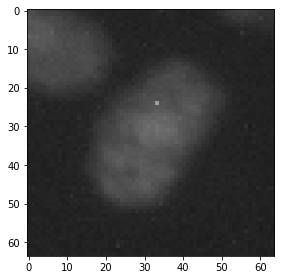

In [37]:
final_shape = (64,64)
all_patches_dir = os.path.join(glimpse_parent_folder, 'all')
files = [fn for fn in os.listdir(all_patches_dir) if '.tif' in fn]

for image_fn in ['Pos0_cell_ID_3183_channel003_t374_age0.708.tif']:# files:
    image_path = os.path.join(all_patches_dir, image_fn)
    image = imread(image_path)
    shape = image.shape
    crop_amount = (shape[0]-final_shape[0])/2
    x1, y1, x2, y2 = int(crop_amount), int(crop_amount), int(crop_amount+final_shape[0]) , int(crop_amount+final_shape[0])
    image = image[x1: x2, y1:y2 ]
    imshow(image)
    break

In [42]:
filtered_files = natsorted([fn for fn in files if 'Pos0_cell_ID_3183' in fn])

In [43]:
filtered_files

['Pos0_cell_ID_3183_channel003_t308_age0.583.tif',
 'Pos0_cell_ID_3183_channel003_t309_age0.585.tif',
 'Pos0_cell_ID_3183_channel003_t310_age0.587.tif',
 'Pos0_cell_ID_3183_channel003_t311_age0.589.tif',
 'Pos0_cell_ID_3183_channel003_t312_age0.591.tif',
 'Pos0_cell_ID_3183_channel003_t313_age0.593.tif',
 'Pos0_cell_ID_3183_channel003_t314_age0.595.tif',
 'Pos0_cell_ID_3183_channel003_t315_age0.597.tif',
 'Pos0_cell_ID_3183_channel003_t316_age0.598.tif',
 'Pos0_cell_ID_3183_channel003_t317_age0.6.tif',
 'Pos0_cell_ID_3183_channel003_t318_age0.602.tif',
 'Pos0_cell_ID_3183_channel003_t319_age0.604.tif',
 'Pos0_cell_ID_3183_channel003_t320_age0.606.tif',
 'Pos0_cell_ID_3183_channel003_t321_age0.608.tif',
 'Pos0_cell_ID_3183_channel003_t322_age0.61.tif',
 'Pos0_cell_ID_3183_channel003_t323_age0.612.tif',
 'Pos0_cell_ID_3183_channel003_t324_age0.614.tif',
 'Pos0_cell_ID_3183_channel003_t325_age0.616.tif',
 'Pos0_cell_ID_3183_channel003_t326_age0.617.tif',
 'Pos0_cell_ID_3183_channel003_t32

# Masking off the background

In [ ]:
masked_output_dir = os.path.join(glimpse_parent_folder, 'all_masked')
Path(masked_output_dir).mkdir(parents=True, exist_ok=True)

all_patches_dir = os.path.join(glimpse_parent_folder, 'all')
files = natsorted([fn for fn in os.listdir(all_patches_dir) if '.tif' in fn])
previous_tracks = []
for fn in tqdm(files):
    pos_name = re.findall("Pos\d", fn)[0]
    cell_ID = int(re.findall("cell_ID_(\d+)", fn)[0])
    
    print(pos_name, cell_ID)
    tracks_path_list = natsorted(glob.glob(os.path.join(expt_root_folder,'{}/{}/gfp*.h5'.format('MK0000',pos_name))))
    if len(tracks_path_list) > 0:
            tracks_path = tracks_path_list[-1]
    else:
        print(pos_name, cell_ID, 'couldnt load tracks')
        continue
    if tracks_path == previous_tracks:
        print(tracks_path, 'already loaded')
    else:
        with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_3") as hdf:
            wt_tracks = hdf.tracks
            print(tracks_path, 'loaded')
            previous_tracks = tracks_path

    ### load xyt, load mask, apply mask to image
    cell = [cell for cell in wt_tracks if cell.ID == cell_ID][0]
    time = int(re.findall("_t(\d+)", fn)[0])
    x, y = cell.x[cell.t.index(time)], cell.y[cell.t.index(time)]
    
    ### load mask 
    mask_dir = os.path.join(expt_root_folder,'{}/{}/{}_cp_masks'.format('MK0000',pos_name, pos_name))
    mask_fn = natsorted(os.listdir(mask_dir))[time]
    mask_image = imread(os.path.join(mask_dir, mask_fn))
    ### load corresponding image
    image = imread(os.path.join(all_patches_dir,fn))
    
    ### crop mask image
    size = int(glimpse_size[0])
    ### obtain coordinates of bounding box of glimpse (centered on cell)
    x1, x2, y1, y2 = x, x+size, y, y+size #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
    ### pad image incase cell goes off FOV
    mask_image_pad = np.pad(mask_image, int(size/2), 'constant', constant_values = 0) 
    ## cropping original image
    cropped_mask = mask_image_pad[int(y1): int(y2), int(x1): int(x2)]#[int(x1): int(x2), int(y1): int(y2)]
    ## finding pixel value of mask of interest
    pix_value = cropped_mask[int(size/2),int(size/2)]
    ### isolating mask of interest and assigning binary pix value
    true_mask = (cropped_mask == pix_value)*1
    ### applying mask to original glimpse
    true_glimpse = (true_mask*image).astype('uint16')
    ### save out
    imsave(os.path.join(masked_output_dir, fn), true_glimpse) 


  0%|          | 0/174706 [00:00<?, ?it/s][INFO][2021/05/30 06:44:03 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5...
INFO:worker_process:Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5...
[INFO][2021/05/30 06:44:03 PM] Loading tracks/obj_type_3
INFO:worker_process:Loading tracks/obj_type_3


Pos0 46


[INFO][2021/05/30 06:44:03 PM] Loading objects/obj_type_3 (563356, 5) (563356 filtered: None)
INFO:worker_process:Loading objects/obj_type_3 (563356, 5) (563356 filtered: None)
[INFO][2021/05/30 06:44:12 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5
INFO:worker_process:Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5


/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 loaded


  0%|          | 1/174706 [00:09<476:36:04,  9.82s/it]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 2/174706 [00:10<204:56:33,  4.22s/it]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 3/174706 [00:10<117:23:59,  2.42s/it]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 4/174706 [00:10<77:03:57,  1.59s/it] 

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 5/174706 [00:10<53:57:14,  1.11s/it]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 6/174706 [00:11<40:19:44,  1.20it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 7/174706 [00:11<31:59:53,  1.52it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 8/174706 [00:11<26:36:40,  1.82it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 9/174706 [00:12<22:21:01,  2.17it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 10/174706 [00:12<19:22:20,  2.50it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 11/174706 [00:12<17:45:37,  2.73it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 12/174706 [00:13<17:11:35,  2.82it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 13/174706 [00:13<15:54:12,  3.05it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 14/174706 [00:13<15:49:27,  3.07it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 15/174706 [00:13<14:59:41,  3.24it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 16/174706 [00:14<15:14:39,  3.18it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 17/174706 [00:14<14:38:20,  3.31it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 18/174706 [00:14<14:43:18,  3.30it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 19/174706 [00:15<15:03:07,  3.22it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 20/174706 [00:15<16:17:16,  2.98it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 21/174706 [00:15<15:32:18,  3.12it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 22/174706 [00:16<15:07:38,  3.21it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 23/174706 [00:16<14:44:08,  3.29it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 24/174706 [00:16<14:55:12,  3.25it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 25/174706 [00:16<14:47:38,  3.28it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 26/174706 [00:17<14:22:45,  3.37it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 27/174706 [00:17<15:23:44,  3.15it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 28/174706 [00:17<14:42:03,  3.30it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 29/174706 [00:18<14:51:30,  3.27it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 30/174706 [00:18<15:42:32,  3.09it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 31/174706 [00:18<15:43:27,  3.09it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 32/174706 [00:19<15:38:04,  3.10it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 33/174706 [00:19<16:28:32,  2.94it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 34/174706 [00:19<16:01:13,  3.03it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 35/174706 [00:20<15:50:03,  3.06it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 36/174706 [00:20<15:14:50,  3.18it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 37/174706 [00:20<15:40:46,  3.09it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 38/174706 [00:21<14:47:18,  3.28it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 39/174706 [00:21<15:02:23,  3.23it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 40/174706 [00:21<15:35:24,  3.11it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 41/174706 [00:22<15:32:16,  3.12it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 42/174706 [00:22<16:05:37,  3.01it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 43/174706 [00:22<15:18:02,  3.17it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 44/174706 [00:23<15:09:41,  3.20it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 45/174706 [00:23<15:08:56,  3.20it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 46/174706 [00:23<14:57:07,  3.24it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 47/174706 [00:24<15:41:28,  3.09it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 48/174706 [00:24<15:04:34,  3.22it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 49/174706 [00:24<15:16:27,  3.18it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 50/174706 [00:24<14:43:19,  3.30it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 51/174706 [00:25<15:22:37,  3.16it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 52/174706 [00:25<15:07:46,  3.21it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 53/174706 [00:25<15:02:36,  3.22it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 54/174706 [00:26<15:14:27,  3.18it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 55/174706 [00:26<14:53:12,  3.26it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 56/174706 [00:26<14:42:18,  3.30it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 57/174706 [00:27<15:14:25,  3.18it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 58/174706 [00:27<14:44:36,  3.29it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 59/174706 [00:27<14:59:15,  3.24it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 60/174706 [00:28<15:24:37,  3.15it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 61/174706 [00:28<15:46:47,  3.07it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 62/174706 [00:28<18:14:34,  2.66it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 63/174706 [00:29<17:54:18,  2.71it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 64/174706 [00:29<17:29:50,  2.77it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 65/174706 [00:29<16:47:29,  2.89it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 66/174706 [00:30<16:14:42,  2.99it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 67/174706 [00:30<16:16:32,  2.98it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 68/174706 [00:30<16:09:05,  3.00it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 69/174706 [00:31<15:55:44,  3.05it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 70/174706 [00:31<15:55:46,  3.05it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 71/174706 [00:31<15:56:45,  3.04it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 72/174706 [00:32<15:49:03,  3.07it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 73/174706 [00:32<16:06:36,  3.01it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 74/174706 [00:32<16:38:35,  2.91it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 75/174706 [00:33<15:30:14,  3.13it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 76/174706 [00:33<15:37:48,  3.10it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 77/174706 [00:33<15:44:33,  3.08it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 78/174706 [00:34<15:43:40,  3.08it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 79/174706 [00:34<14:50:22,  3.27it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 80/174706 [00:34<15:07:22,  3.21it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 81/174706 [00:35<15:32:56,  3.12it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 82/174706 [00:35<14:47:05,  3.28it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 83/174706 [00:35<14:22:53,  3.37it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 84/174706 [00:35<14:43:34,  3.29it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 85/174706 [00:36<14:56:09,  3.25it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 86/174706 [00:36<14:43:22,  3.29it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 87/174706 [00:36<15:11:39,  3.19it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 88/174706 [00:37<14:59:59,  3.23it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 89/174706 [00:37<14:30:27,  3.34it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 90/174706 [00:37<14:59:46,  3.23it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 91/174706 [00:38<15:25:25,  3.14it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 92/174706 [00:38<15:57:00,  3.04it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 93/174706 [00:38<16:17:33,  2.98it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 94/174706 [00:39<16:25:52,  2.95it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 95/174706 [00:39<17:07:07,  2.83it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 96/174706 [00:39<16:21:09,  2.97it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 97/174706 [00:40<16:15:35,  2.98it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 98/174706 [00:40<16:57:16,  2.86it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 99/174706 [00:40<16:41:48,  2.90it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 100/174706 [00:41<16:03:50,  3.02it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 101/174706 [00:41<15:34:04,  3.12it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 102/174706 [00:41<15:31:25,  3.12it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 103/174706 [00:42<15:50:23,  3.06it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 104/174706 [00:42<15:41:48,  3.09it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 105/174706 [00:42<14:52:08,  3.26it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 106/174706 [00:43<14:36:16,  3.32it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 107/174706 [00:43<14:38:59,  3.31it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 108/174706 [00:43<15:04:54,  3.22it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 109/174706 [00:43<15:18:29,  3.17it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 110/174706 [00:44<15:33:09,  3.12it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 111/174706 [00:44<15:46:03,  3.08it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 112/174706 [00:44<15:42:36,  3.09it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 113/174706 [00:45<15:37:30,  3.10it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 114/174706 [00:45<15:56:12,  3.04it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 115/174706 [00:46<16:36:17,  2.92it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 116/174706 [00:46<16:32:20,  2.93it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 117/174706 [00:46<15:30:12,  3.13it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 118/174706 [00:46<16:04:14,  3.02it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 119/174706 [00:47<15:34:09,  3.11it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 120/174706 [00:47<15:22:53,  3.15it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 121/174706 [00:47<15:57:30,  3.04it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 122/174706 [00:48<15:53:56,  3.05it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 123/174706 [00:48<16:14:36,  2.99it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 124/174706 [00:48<16:29:08,  2.94it/s]

Pos0 46
/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5 already loaded


  0%|          | 125/174706 [00:49<15:48:42,  3.07it/s]

In [167]:
fn

'Pos0_cell_ID_1445_channel003_t96_age0.0.tif'

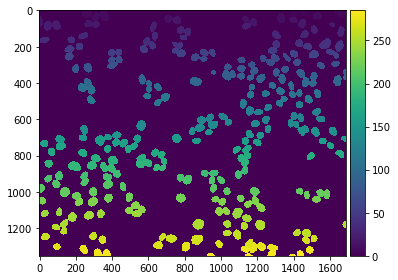

In [165]:
imshow(mask_image)

In [177]:
x, y

(637.6248168945312, 142.41329956054688)

In [166]:
mask_fn

'img_channel001_position000_time000000096_z000_cp_masks.png'

In [140]:
size = int(glimpse_size[0])
### obtain coordinates of bounding box of glimpse (centered on cell)
x1, x2, y1, y2 = x, x+size, y, y+size #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
### pad image incase cell goes off FOV
mask_image_pad = np.pad(mask_image, int(size/2), 'constant', constant_values = 0) 
## glimpse creation by cropping original image
cropped_mask = mask_image_pad[int(y1): int(y2), int(x1): int(x2)]#transposed 

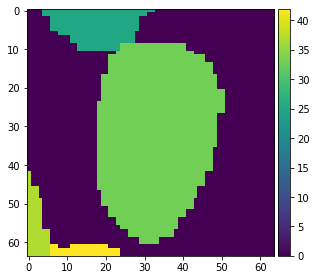

In [168]:
imshow(cropped_mask)

In [151]:
int(size/2)

32

In [170]:
pix_value = cropped_mask[int(size/2),int(size/2)]

In [171]:
pix_value

33

In [174]:
im_bool = (cropped_mask == pix_value)*1

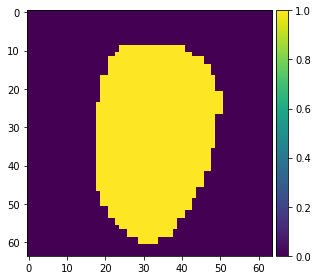

In [175]:
imshow(im_bool)

In [179]:
os.path.join(all_patches_dir, fn)

'/home/nathan/data/kraken/pcna/glimpses/MK0000/all/Pos0_cell_ID_1445_channel003_t96_age0.0.tif'

In [181]:
image = imread(os.path.join(all_patches_dir, fn))

In [182]:
image*im_bool

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

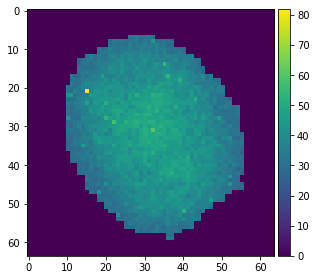

In [190]:
imshow(true_glimpse)

In [191]:
type(true_glimpse)

TypeError: type() takes 1 or 3 arguments

In [192]:
type(image)

numpy.ndarray

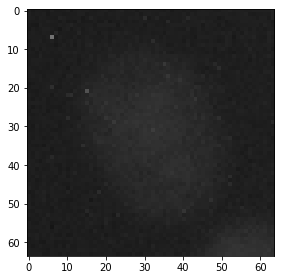

In [189]:
imshow(image)

In [194]:
imread(os.path.join(masked_output_dir, 'Pos0_cell_ID_46_channel003_t0_age0.0.tif'))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [126]:
cell

,ID,t,x,y,z,parent,root,state,generation,dummy,major_axis_length,area
0,46,0,41.487602,719.188599,0.000000,46,46,5,0,False,43.942135,1331.0
1,46,1,43.503052,723.246582,0.000000,46,46,5,0,False,43.358578,1310.0
2,46,2,43.790398,723.562500,0.000000,46,46,5,0,False,44.607243,1312.0
3,46,3,39.327244,725.302124,0.000000,46,46,5,0,False,43.106945,1314.0
4,46,4,35.341015,727.930115,0.000000,46,46,5,0,False,42.836525,1302.0
5,46,5,34.491714,729.960510,0.000000,46,46,5,0,False,41.953842,1267.0
6,46,6,35.250721,730.286011,0.000000,46,46,5,0,False,44.813995,1388.0
7,46,7,38.582970,730.583679,0.000000,46,46,5,0,False,43.882397,1374.0
8,46,8,39.283382,731.157654,0.000000,46,46,5,0,False,46.456879,1408.0
9,46,9,40.179825,731.876709,0.003984,46,46,5,0,True,NaN,NaN


In [128]:
y

719.1885986328125

In [129]:
x1, x2, y1, y2

(41.48760223388672, 105.48760223388672, 719.1885986328125, 783.1885986328125)

In [142]:
tracks_path

'/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_28_06_28_16_PM.h5'